In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.io as sio
import mat73
import gseapy
from gseapy import barplot, dotplot
import glob
import polars as pl
import logomaker
from Bio.Seq import Seq
from Bio.pairwise2 import format_alignment
from Bio import pairwise2
from Bio import motifs
import os
from itertools import repeat
from collections import Counter
%config InlineBackend.figure_format='retina'
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42

/home/labs/barkailab/vovam/miniconda/envs/mammalian/lib/python3.10/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


In [23]:
# Matrix of log2(DMSO/IAA) (that was easier for me because this way >0 means that gene was upregulated in presence of target TF)
expression = pd.read_csv('data/expression_log2fc.csv', index_col=0)

# Matrix of Sum of Read on Promoters per TF (SumProm)
chec = pd.read_csv('data/chec_sumprom.csv', index_col=0)

# Zscore normaliztion and num of targets extraction
zscored = (chec - chec.mean()) / chec.std()
zscored_bs = zscored.apply(lambda x: (x>=3).sum())

# Misc dataframes with gene/promter definitions and nucleotide sequences of promoters
prom_definitions = pd.read_csv('data/promoter_definitions.csv', index_col=0)
prom_sequences = pd.read_csv('data/promoter_sequences.csv', index_col=0)

# Data from Supp Table incicating number of targets per TF 
total_bs = pd.read_excel('data/41586_2025_8916_MOESM3_ESM.xlsx', sheet_name='table_S1a', index_col=0).loc[:, 'Total binding sites'].dropna().loc[chec.columns]

# Genes defined as Environmental Stress Reponse induced(stress) and repressed(ribosomal) from https://pmc.ncbi.nlm.nih.gov/articles/PMC15070/
with open ('data/misc/ribosomal_genes.txt', 'r') as f:
    ribo_genes = f.read().split('\n')
with open ('data/misc/stress_gens.txt', 'r') as f:
    stress_genes = f.read().split('\n')    





In [9]:
motifs_id = pd.read_csv('/home/labs/barkailab/vovam/Yeast_General_Data/cis_bp/tf_cisbp_mot_map.csv', index_col=0)

In [10]:
mot_con = set(chec.columns).intersection(motifs_id.dropna().index)

In [11]:
# import scipy.stats as stats
import pickle
with open('/home/labs/barkailab/vovam/submission_git/ads_coac_guide_binding_and_transc/data/nuc_struct.pkl', 'rb') as f:
    nucchr = pd.DataFrame(pickle.load(f))

In [12]:
def draw_arrow(ax, coords, hw, hl, wd, ya,s, text):
    start = coords[0]
    stop = coords[1]
    if (start-stop) > 0:
        ax.arrow(start, ya, -(start-stop)+hl,0, head_width=hw, head_length=hl, width=wd, fc='gainsboro', ec='black', lw=.5)
    else:
        ax.arrow(start, ya, (stop-start)-hl,0, head_width=hw, head_length=hl, width=wd, fc='gainsboro', ec='black', lw=.5)
    ax.text((min(start,stop)+np.abs(stop-start)/4), ya+10, text, size=s)

def draw_line(ax, coord, c='k', lw=.5, ls='--'):
    ax.axvline(coord, c=c, lw=lw, ls=ls)
    
def draw_promoter(chrom, start_gene,lim_data, mean_data, nucchr=nucchr,  title='', save=False, gp=gp, verified=True):
    chrom = chrom
    startchr = start_gene-6000
    stopchr = start_gene+6000
    if verified:
        genecoords = (gp.query("chr_loc==@chrom & start>@startchr & stop<@stopchr & status=='Verified ORF'").loc[:, ['start', 'stop']].applymap(lambda x: int(x)) - startchr).clip(0)
    else:
        genecoords = (gp.query("chr_loc==@chrom & start>@startchr & stop<@stopchr").loc[:, ['start', 'stop']].applymap(lambda x: int(x)) - startchr).clip(0)

    tracks = mean_data.loc[chrom].apply(lambda x: x[startchr:stopchr])
    fig, ax = plt.subplots(tracks.shape[0]+2,1, constrained_layout=False, sharex=True, sharey=False, dpi=150, figsize=(5,1.5))

    m_track = tracks.apply(lambda x: max(x))

    
    colors = ['indigo', 'maroon', 'chocolate', 'darkgreen', 'navy', 'steelblue', 'pink', 'royalblue', 'olive']
    
    maxy = []
    for tfi, axi, colori in zip(mean_data.columns, ax[1:], colors):
        plot_vec = tracks.loc[tfi]
        axi.fill_between(np.arange(plot_vec.shape[0]), plot_vec,color=colori,lw=.8)
        sns.despine(ax=axi, top=True, right=True)
        axi.set_ylabel(tfi, size=6, rotation=0, labelpad=20)
        axi.yaxis.label.set_color(colori)
        axi.set_xlim([-10,stopchr-startchr])
        # axi.set_ylim([-5, ])
        
        if m_track.loc[tfi] > lim_data[tfi]:
            axi.set_ylim([-5, m_track.loc[tfi]])
            maxy.append(m_track.loc[tfi])
        else:
            axi.set_ylim([-5, lim_data[tfi]])
            maxy.append(lim_data[tfi])
        axi.set_yticklabels(axi.get_yticklabels(), size=5)
        axi.tick_params(bottom=False, left=False)
    ax[0].set_ylim([0, 100])
    hw = 30
    hl = 50
    wd = 10
    ya = 50
    ts = 5
    for i in range(genecoords.shape[0]):
        text = genecoords.index[i]
        draw_arrow(ax[0], genecoords.values[i], hw, hl, wd, ya, ts, text)
        for axi in ax[1:]:
            draw_line(axi, genecoords.values[i][0])

    ax[0].tick_params(bottom=False, left=False)

    ax[0].set_yticklabels('')
    sns.despine(ax=ax[0], top=True, right=True, bottom=True, left=True)


    ax[-1].fill_between(range(stopchr-startchr), nucchr.loc[chrom].apply(lambda x: x[startchr:stopchr]).values[0], color='gainsboro')
    ax[-1].set_yticklabels('')
    ax[-1].set_ylabel('MNase-seq', size=6, rotation=0, labelpad=20)
    ax[-1].set_xticklabels('')
    ax[-1].tick_params(bottom=False, left=False)

    sns.despine(ax=ax[-1], top=True, right=True, bottom=False)
    fig.subplots_adjust(hspace=0.2)

    y = max(tracks.apply(lambda x: max(x))) * 0.7
    
    y = maxy[0] * 0.7
    ax[1].plot([(stopchr-startchr)-1000,(stopchr-startchr)-500],[y,y], c='k')
    ax[1].text((stopchr-startchr)-1000, y+2, '500bp', size=7)

    ax[-1].set_xlabel('Chr{} {}..{} ({}kb)'.format(chrom, startchr, stopchr, (stopchr-startchr)/1000), size=6)
    
    if save:
        fig.savefig(save)
        
def plot_proms_motifs_comp(tf, zscored, chec, total_bs, prom_background, z_thresh=3.5, save=False, analyze_only=False, motifs_id=motifs_id):
    t_mot = parse_cisbp_motif(os.path.join('data/pwms_all_motifs/',motifs_id.loc[tf].values[0]+'.txt'))
    
    if (np.isinf(pd.DataFrame(t_mot.pssm)).sum().sum()>0):
        t_mot.pseudocounts= 0.1
        
    tfd = zscored.loc[:, tf]
    tind = tfd[(tfd>=z_thresh).values].index
    x = chec.loc[:, tf].sort_values()
    x = x/x.max()
    z_thresh = x.loc[tind].min()

    h_thresh = x.iloc[-int(total_bs.loc[tf]):].min()
    # return x
    dist = t_mot.pssm.distribution(background=prom_background)
    threshold = dist.threshold_balanced(1000)
    mot_calc = genes.loc[x[::-1].index, 'seq'].apply(lambda x: np.sum(t_mot.reverse_complement().pssm.calculate(x)>threshold) + np.sum(t_mot.pssm.calculate(x)>threshold))
    for_hist = pd.DataFrame(x[::-1])
    for_hist = pd.concat([for_hist, mot_calc], axis=1)
    for_hist.loc[tind, 'targets'] = 'z-score'
    for_hist.iloc[len(tind):int(total_bs.loc[tf])].loc[:,'targets'] = 'peaks'
    for_hist.targets = for_hist.targets.fillna('not bound')
    for_hist.columns = ['signal', 'mot_n', 'targets']
    max_sig = for_hist.signal.max()
    thresh_gen = lambda x: max_sig * x
    threshl = list(map(thresh_gen, np.arange(0,1.05,.05)))[::-1]



    quant=[]
    for t,q in zip(threshl,np.arange(0,1.05,.05)[::-1]):
        quant.extend(list(zip(for_hist.query("signal<=@t").index, repeat(q))))

    for_hist = pd.concat([for_hist, pd.DataFrame(quant).groupby(0).min().loc[for_hist.index],  chec.loc[:, tf].sort_values()], axis=1)
    for_hist.columns = ['signal', 'mot_n', 'targets', 'perc', 'sumprom']
    if analyze_only:
        return for_hist
    # fig, (ax,ax1)= plt.subplots(2,1, figsize=(10,3),  dpi=300, constrained_layout=True)
    fig, ax= plt.subplots(1, figsize=(10,1),  dpi=300, constrained_layout=True)

    # ax.scatter(x, np.zeros(chec.shape[0]), s=100, c='gainsboro', zorder=20, ec='k', lw=.3, rasterized=True)

    vmax = mot_calc.loc[tind].median()
    vmax = 3
    s = ax.scatter(x, np.zeros(chec.shape[0]), s=100, c=mot_calc[::-1], zorder=20, vmax=vmax, cmap='Reds', rasterized=True, linewidths=0)

    fig.colorbar(s, label='Mot number')
    ax.set_ylim([-0.22, 0.22])
    # ax.set_xlim([5,20])
    # ax.fill_betweenx(y=[-.22,0.22], x1 = h_thresh, x2 = x.max(), color='#abeaa2', linewidth=0, label='Peaks in Promoters')
    # ax.fill_betweenx(y=[-.2,0.2], x1 = z_thresh, x2 = x.max(), color='#c8a8da', linewidth=0, label='Sum Reads in Promoters (zscore>=3.5)')

    ax.axvline(h_thresh, c='red', zorder=20)
    ax.axvline(z_thresh, c='green')

    ax.text(h_thresh + (z_thresh-h_thresh)/2, .3, int(total_bs.loc[tf]))
    ax.text(z_thresh + (x.max() - z_thresh)/2, .3, len(tind))
    ax.axhline(0, c='k', lw=.5)

    ax.set_yticklabels('')
    ax.set_xlabel('Promoter Strength')

    ax.tick_params(axis='y', length=0)
    ax.set_xticks(np.arange(0,1.1,0.1))
    sns.despine(ax=ax, right=True, top=True, left=True)
    ax.set_ylabel(tf)

    axin1 = ax.inset_axes([-0.2, 0.4, 0.1, 0.45])
    logomaker.Logo(pd.DataFrame(t_mot.pssm), ax=axin1)
    axin1.set_ylim([0,2])
    axin1.set_xticklabels('')
    axin1.set_yticklabels('')
    axin1.tick_params(axis='y', length=0)
    axin1.tick_params(axis='x', length=0)

    sns.despine(ax=axin1, top=True, left=True, bottom=True)
    


#     tp = for_hist.loc[:, ['mot_n', 'perc']].groupby('perc').median()
#     s = ax1.scatter(tp.index, np.zeros(tp.shape[0]), c=tp.values, vmax=4)
#     fig.colorbar(s, label='median mot N\nin bin')
#     sns.despine(ax=ax1, right=True, top=True, left=True)
#     ax1.tick_params(axis='y', length=0)
#     ax1.set_yticklabels('')

#     xlabels = list(zip(['N', 0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
#            0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95,],
#     ['B', 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
#            0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1 ]))

#     xlabels = ['-'.join(map(str, x)) for x in xlabels]
#     ax1.set_xticks(np.arange(0,1.05,.05), labels=xlabels, rotation=90)
    if save:
        fig.savefig(save)
    return for_hist
def parse_cisbp_motif(path):
    with open(path, 'r') as f:
        a = motifs.read(f, fmt='pfm-four-columns')
    return a

In [7]:
a = Seq(''.join(genes.seq.values).upper())
seq_count = pd.DataFrame(Counter(a), index=['nuc']).T
total_bp = seq_count.sum().values[0]
a_t = (seq_count.loc[['A','T']].sum() / total_bp)/2

g_c = (seq_count.loc[['G','C']].sum() / total_bp)/2

prom_background = {'A':a_t.values[0], 'T':a_t.values[0], 'G':g_c.values[0], 'C':g_c.values[0]}

In [8]:
# for i,tf in enumerate(mot_con):
#     if i % 25 == 0:
#         print(f"{i}/{len(mot_con)}")
#     ndf = plot_proms_motifs_comp(tf, zscored=zscored, chec=chec, total_bs=total_bs, prom_background=prom_background, save=False, analyze_only=True)
#     ndf.to_parquet(f'mot_calc_dfs/{tf}_calc_df.parquet')
    

/tmp/ipykernel_1903777/2889204343.py:106: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  for_hist.iloc[len(tind):int(total_bs.loc[tf])].loc[:,'targets'] = 'peaks'


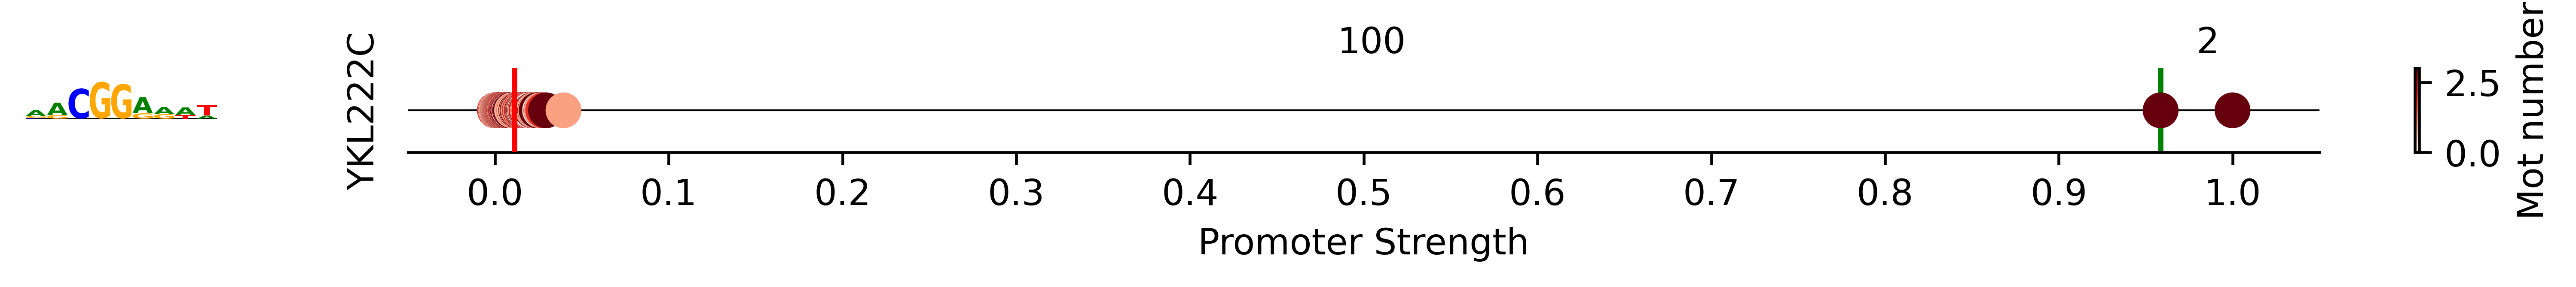

In [9]:
x = plot_proms_motifs_comp('YKL222C', zscored=zscored, chec=chec, total_bs=total_bs, prom_background=prom_background, save='Figures_reply/ykl222c.pdf')

/tmp/ipykernel_1903777/2889204343.py:106: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  for_hist.iloc[len(tind):int(total_bs.loc[tf])].loc[:,'targets'] = 'peaks'


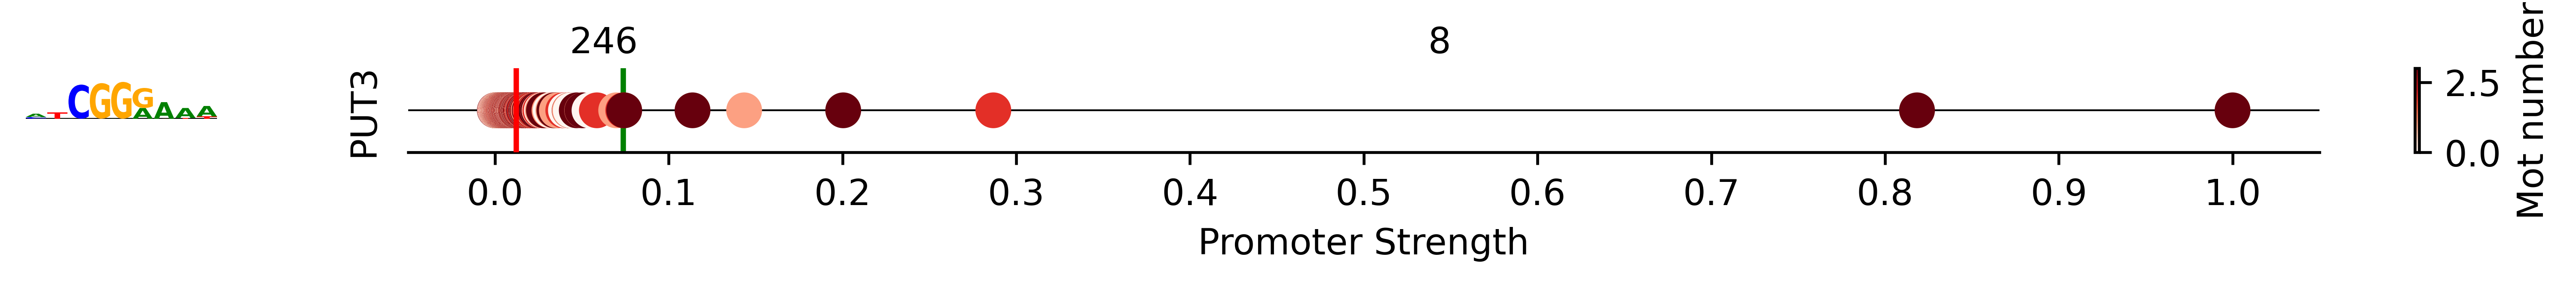

In [10]:
_ = plot_proms_motifs_comp('PUT3', zscored=zscored, chec=chec, total_bs=total_bs, prom_background=prom_background, save='Figures_reply/put3.pdf')

/tmp/ipykernel_1903777/2889204343.py:106: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  for_hist.iloc[len(tind):int(total_bs.loc[tf])].loc[:,'targets'] = 'peaks'


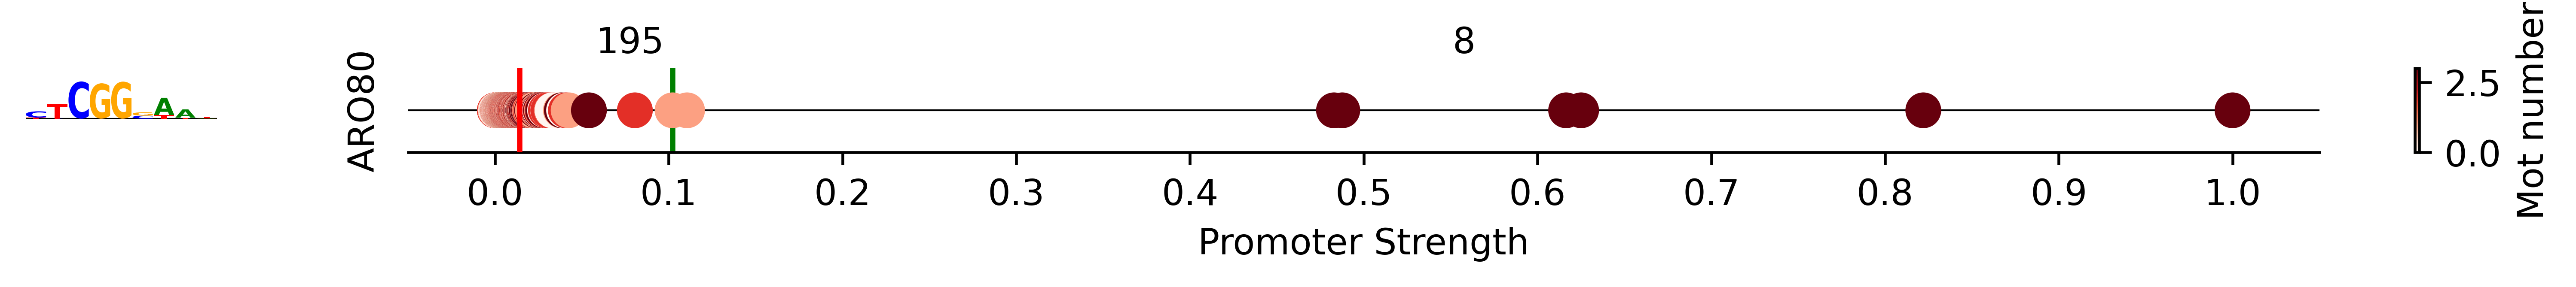

In [11]:
_ = plot_proms_motifs_comp('ARO80', zscored=zscored, chec=chec, total_bs=total_bs, prom_background=prom_background, save='Figures_reply/aro80.pdf')

/tmp/ipykernel_1903777/2889204343.py:106: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  for_hist.iloc[len(tind):int(total_bs.loc[tf])].loc[:,'targets'] = 'peaks'


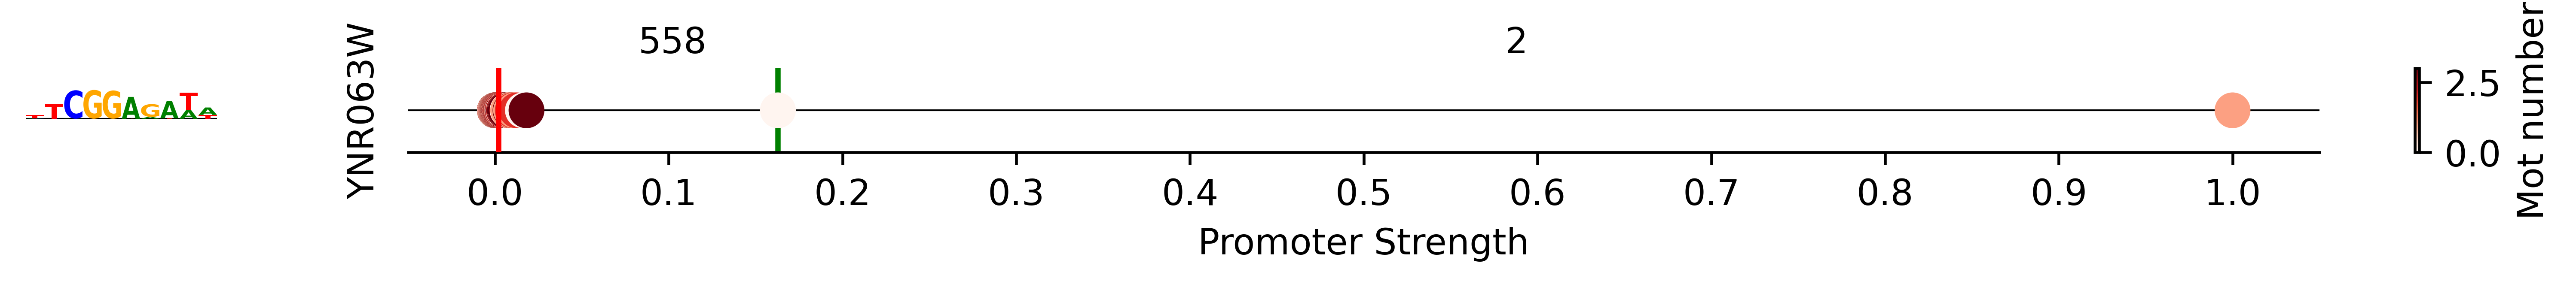

In [12]:
_ = plot_proms_motifs_comp('YNR063W', zscored=zscored, chec=chec, total_bs=total_bs, prom_background=prom_background, save='Figures_reply/YNR063W.pdf')

/tmp/ipykernel_1903777/2889204343.py:106: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  for_hist.iloc[len(tind):int(total_bs.loc[tf])].loc[:,'targets'] = 'peaks'


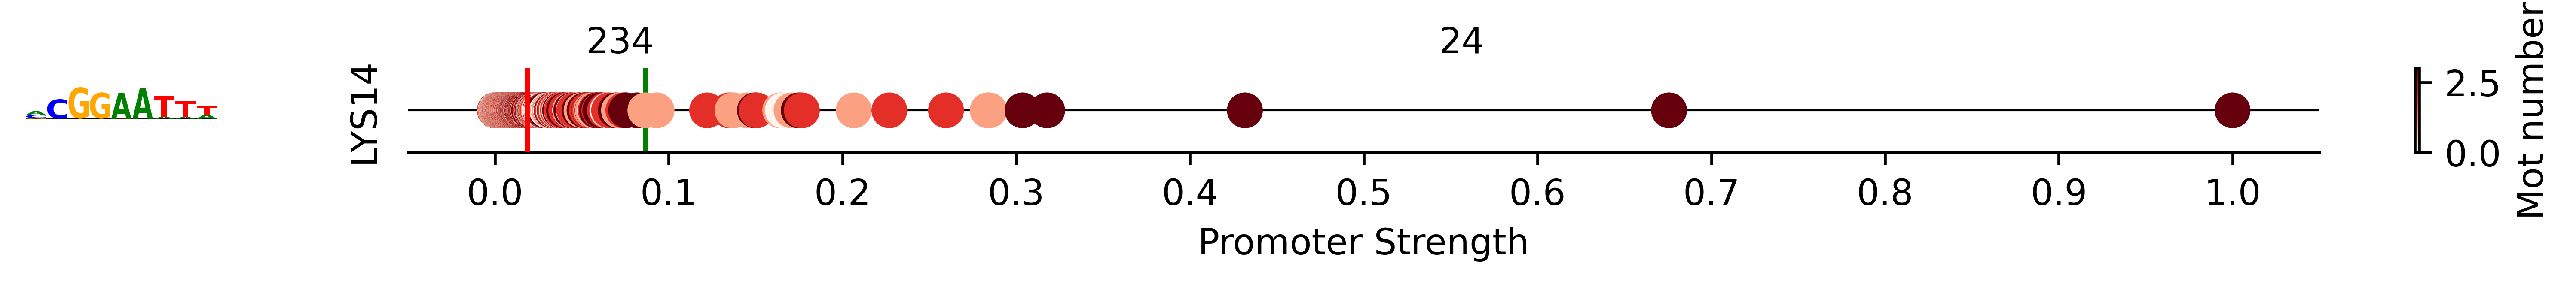

In [13]:
lys_data = plot_proms_motifs_comp('LYS14', zscored=zscored, chec=chec, total_bs=total_bs, prom_background=prom_background, save='Figures_reply/lys14.pdf')

/tmp/ipykernel_1903777/2889204343.py:106: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  for_hist.iloc[len(tind):int(total_bs.loc[tf])].loc[:,'targets'] = 'peaks'


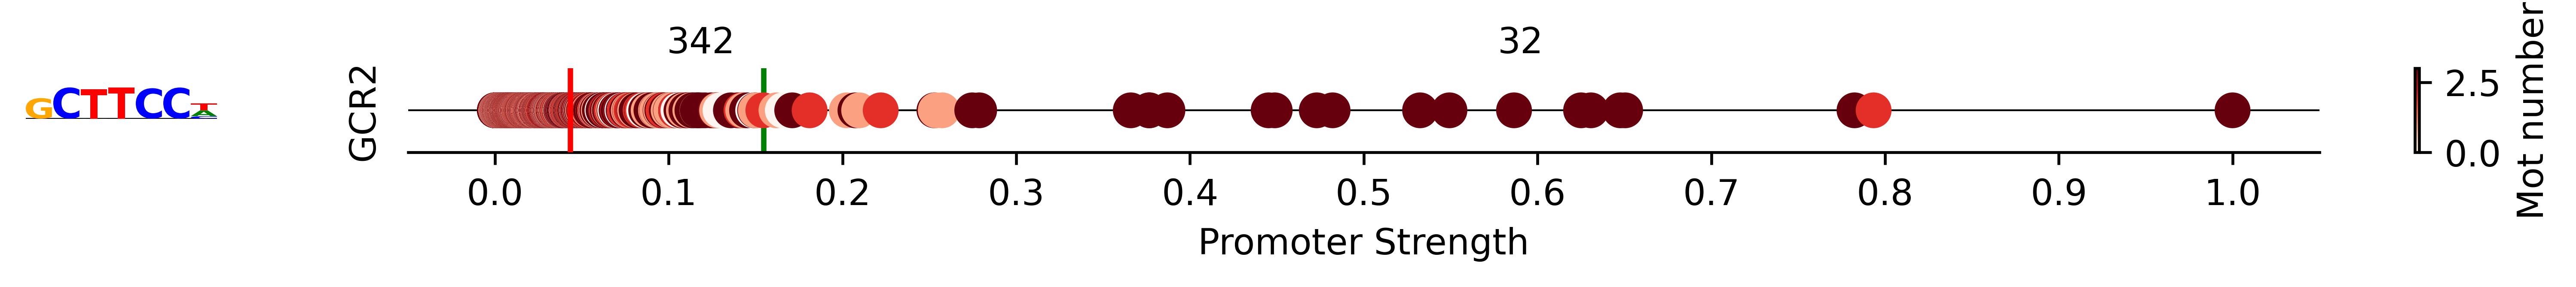

In [14]:
gcr_data = plot_proms_motifs_comp('GCR2', zscored=zscored, chec=chec, total_bs=total_bs, prom_background=prom_background, save='Figures_reply/gcr2.pdf')

/tmp/ipykernel_1903777/2889204343.py:106: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  for_hist.iloc[len(tind):int(total_bs.loc[tf])].loc[:,'targets'] = 'peaks'


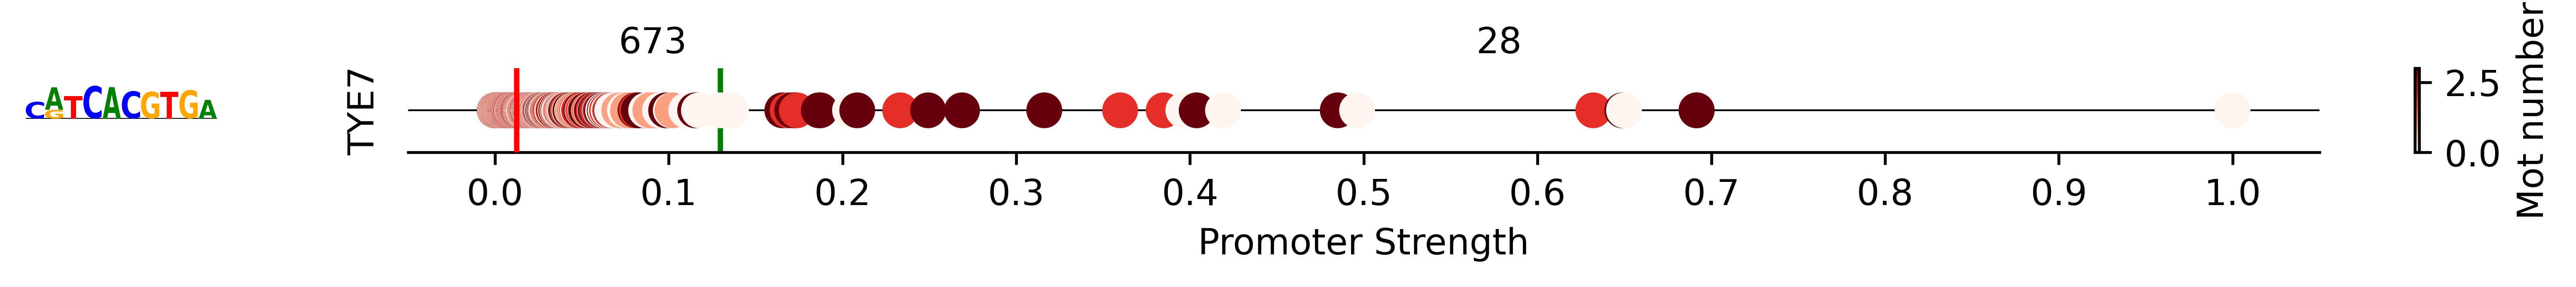

In [15]:
tye_data = plot_proms_motifs_comp('TYE7', zscored=zscored, chec=chec, total_bs=total_bs, prom_background=prom_background, save='Figures_reply/tye7.pdf')

/tmp/ipykernel_1903777/2889204343.py:106: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  for_hist.iloc[len(tind):int(total_bs.loc[tf])].loc[:,'targets'] = 'peaks'


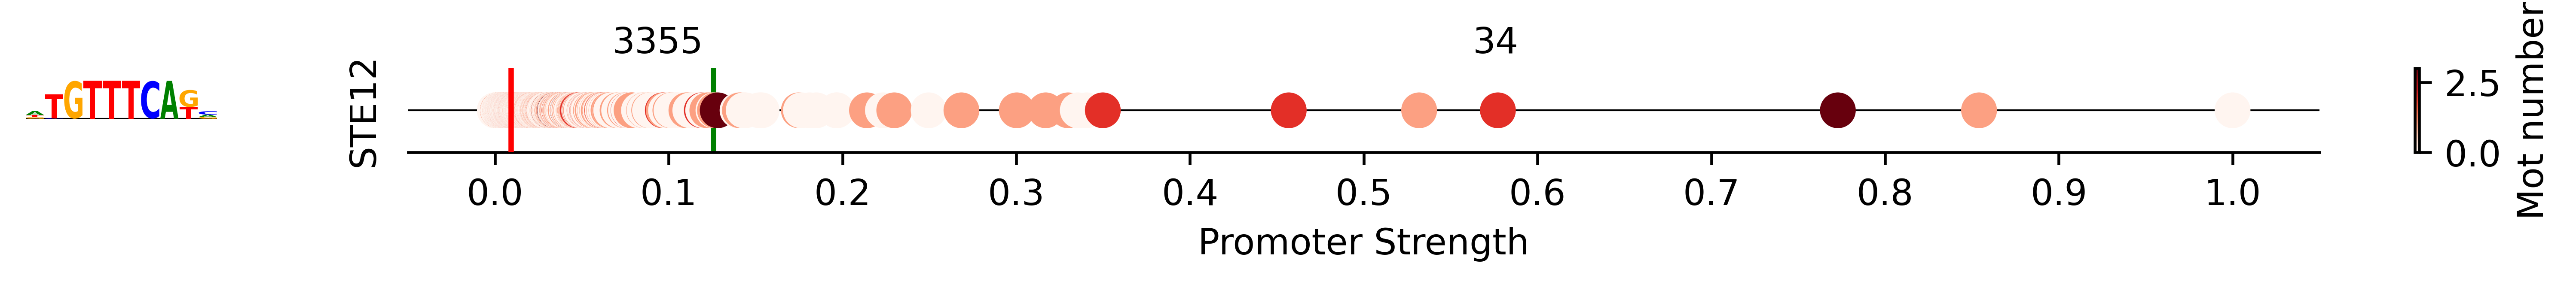

In [16]:
ste12_data = plot_proms_motifs_comp('STE12', zscored=zscored, chec=chec, total_bs=total_bs, prom_background=prom_background, save='Figures_reply/ste.pdf')

In [17]:
alpha = pd.read_csv('alpha_factor_data/2010.alpha_conc.pcl', delimiter='\t', index_col=0).drop('EWEIGHT').drop('GWEIGHT', axis=1)
alpha_genes = pd.Index(gp.reset_index().reset_index().set_index('orf').loc[alpha.index.drop(['YBL100W-A', 'YBL100W-B'])].loc[:, 'index'])
alpha_for_ste12 = df_for_sp.loc[sorted(list(set(df_for_sp.index).intersection(alpha_genes)))].loc[:, 'name'].values
alpha = alpha.loc[gp.reset_index().loc[df_for_sp.loc[sorted(list(set(df_for_sp.index).intersection(alpha_genes)))].index].loc[:, 'orf']]
alpha = alpha[~alpha.index.duplicated(keep='first')]

alpha.index = df_for_sp.loc[sorted(list(set(df_for_sp.index).intersection(alpha_genes)))].loc[:, 'name']

In [18]:
for_comp = ste12_data.loc[alpha.index].sort_values(by='perc', ascending=False)

/tmp/ipykernel_1903777/399494849.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


Text(0.5, 0, 'Alpha factor Conc')

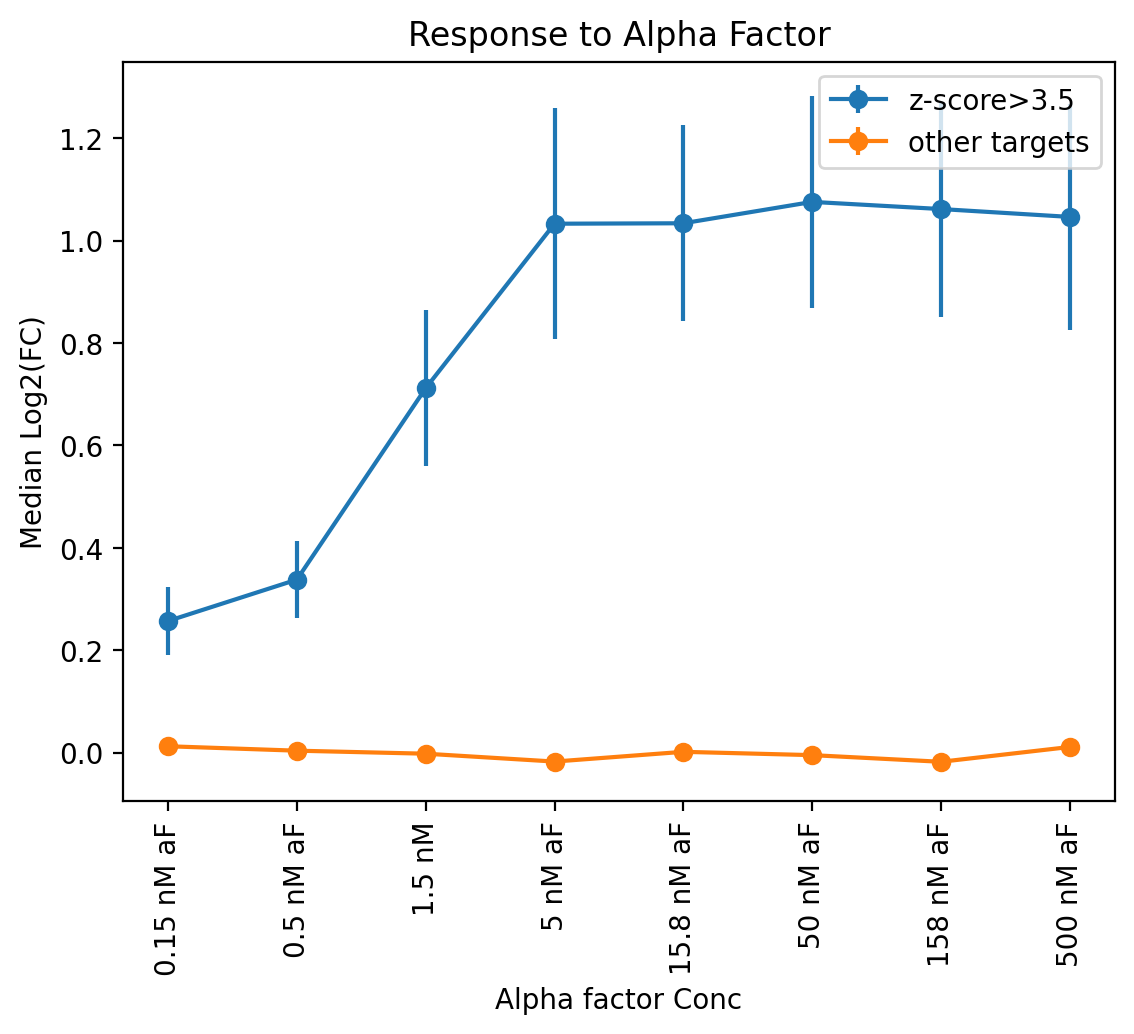

In [19]:
fig, ax = plt.subplots(1)
y = alpha.loc[for_comp.query("targets=='z-score'").index].drop("NAME", axis=1).mean()
x = y.index
err = alpha.loc[for_comp.query("targets=='z-score'").index].drop("NAME", axis=1).sem()
ax.errorbar(x,y,yerr=err, marker='o', label='z-score>3.5')


y = alpha.loc[for_comp.query("targets=='peaks'").index].drop("NAME", axis=1).mean()
x = y.index
err = alpha.loc[for_comp.query("targets=='peaks'").index].drop("NAME", axis=1).sem()
ax.errorbar(x,y,yerr=err, marker='o', label='other targets')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.legend()
ax.set_title('Response to Alpha Factor')
ax.set_ylabel('Median Log2(FC)')
ax.set_xlabel('Alpha factor Conc')

/tmp/ipykernel_1903777/807296889.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


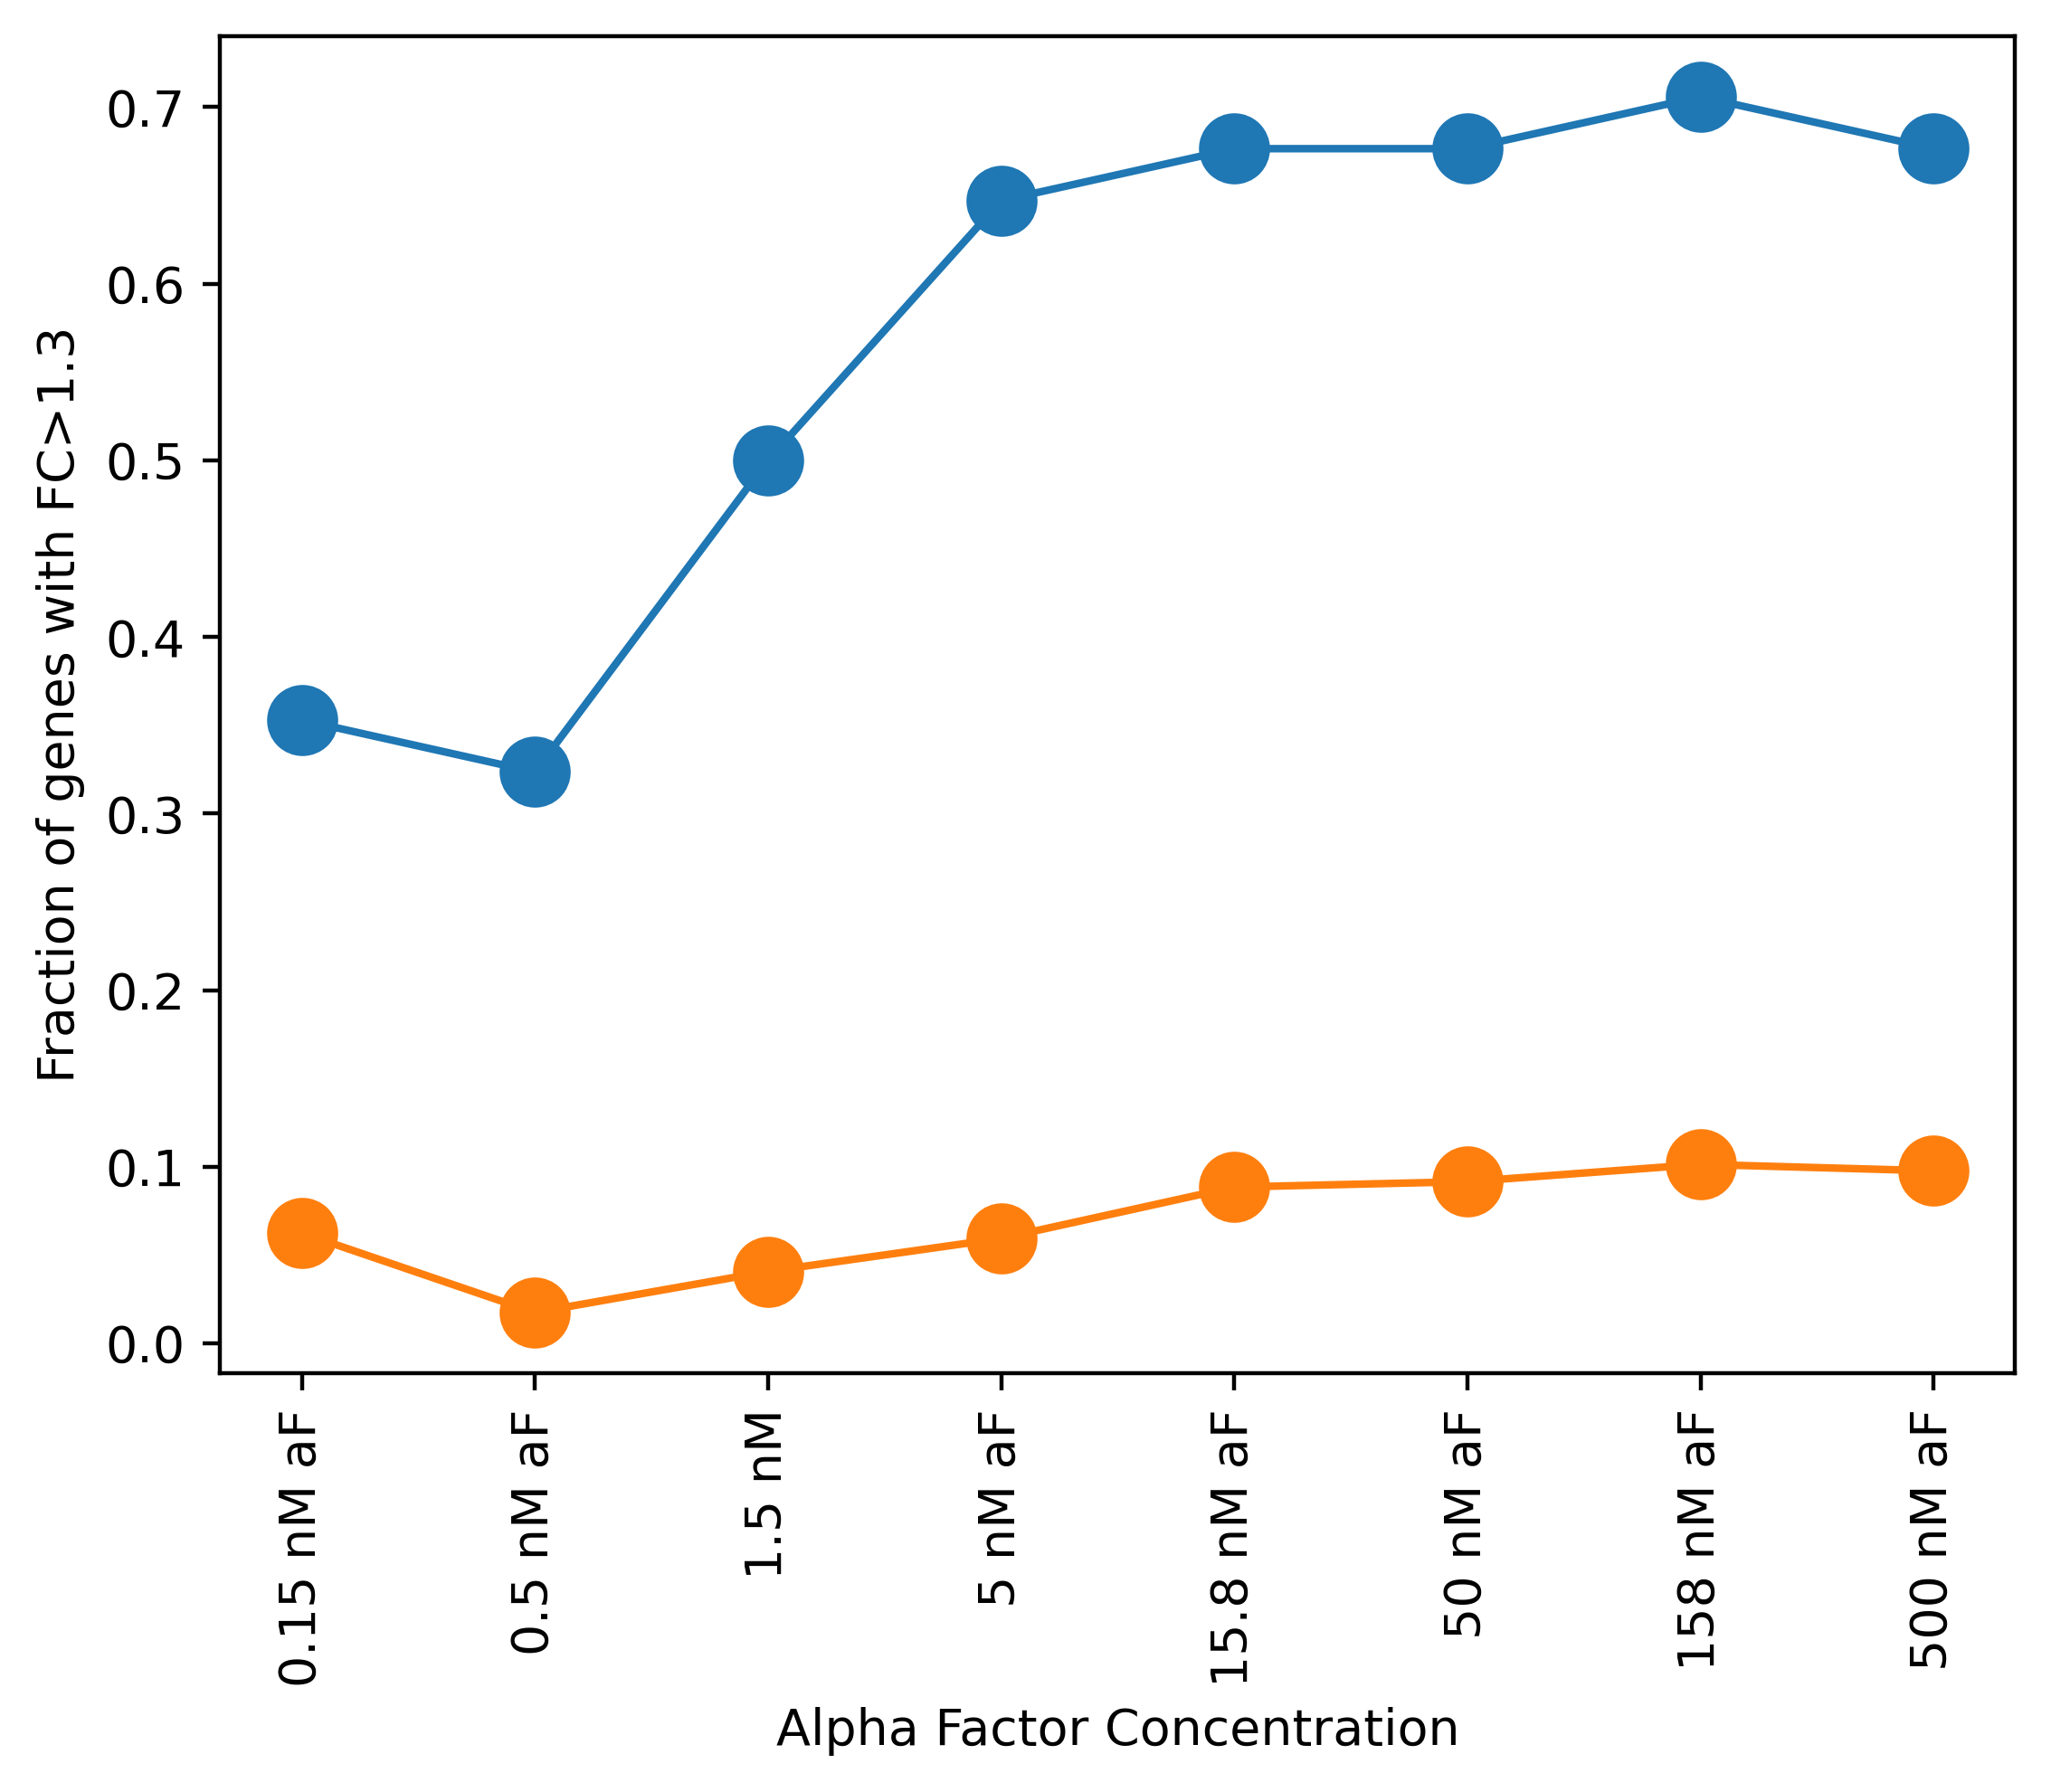

In [20]:
fig, ax = plt.subplots(1, dpi=200)

us_fracs = ((alpha.loc[for_comp.query("targets=='z-score'").index].drop("NAME", axis=1)>np.log2(1.3)).sum() / for_comp.query("targets=='z-score'").index.shape[0])
ax.plot(us_fracs.index, us_fracs)
ax.scatter(us_fracs.index, us_fracs, label='z-score',s=200, lw=0)

them_fracs = ((alpha.loc[for_comp.query("targets=='peaks'").index].drop("NAME", axis=1)>np.log2(1.3)).sum() / for_comp.query("targets=='peaks'").index.shape[0])
ax.plot(them_fracs.index, them_fracs)
ax.scatter(them_fracs.index, them_fracs, label='other targets',s=200, lw=0)

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_xlabel('Alpha Factor Concentration')
ax.set_ylabel("Fraction of genes with FC>1.3")
fig.savefig("Figures_reply/STE12_alpha_response.pdf")

/tmp/ipykernel_1903777/820513369.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  tracks_maxes = nnorm.applymap(lambda x: np.max(x)).quantile(0.2).to_dict()
/tmp/ipykernel_1903777/2889204343.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  genecoords = (gp.query("chr_loc==@chrom & start>@startchr & stop<@stopchr").loc[:, ['start', 'stop']].applymap(lambda x: int(x)) - startchr).clip(0)
/tmp/ipykernel_1903777/2889204343.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axi.set_yticklabels(axi.get_yticklabels(), size=5)


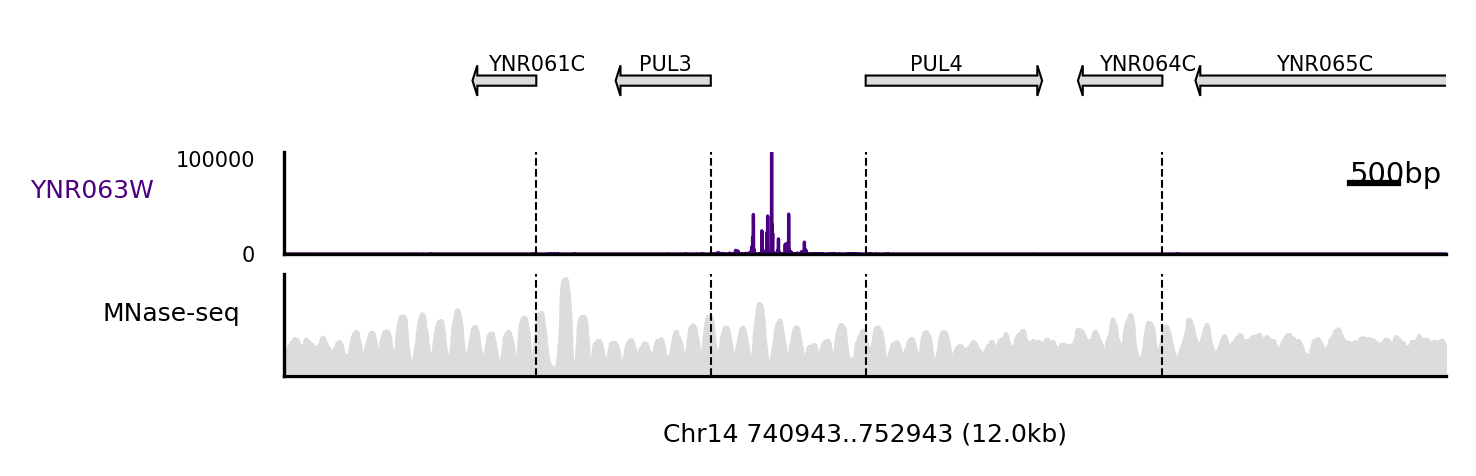

In [21]:
tf='YNR063W'
nnorm = pd.read_parquet(f'outfiles/results/norms/norm_{tf}.gz')
tracks_maxes = nnorm.applymap(lambda x: np.max(x)).quantile(0.2).to_dict()
a,b = df_for_sp.set_index('name').loc['YNR063W', ['chr_loc', 'start']].values.astype(int)
draw_promoter(a,b,tracks_maxes, mean_data=nnorm,  title='', save='Figures_reply/ynr063W_track.pdf', gp=gp, verified=False)

/tmp/ipykernel_1903777/800345812.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  tracks_maxes = nnorm.applymap(lambda x: np.max(x)).quantile(0.2).to_dict()
/tmp/ipykernel_1903777/2889204343.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  genecoords = (gp.query("chr_loc==@chrom & start>@startchr & stop<@stopchr").loc[:, ['start', 'stop']].applymap(lambda x: int(x)) - startchr).clip(0)
/tmp/ipykernel_1903777/2889204343.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axi.set_yticklabels(axi.get_yticklabels(), size=5)


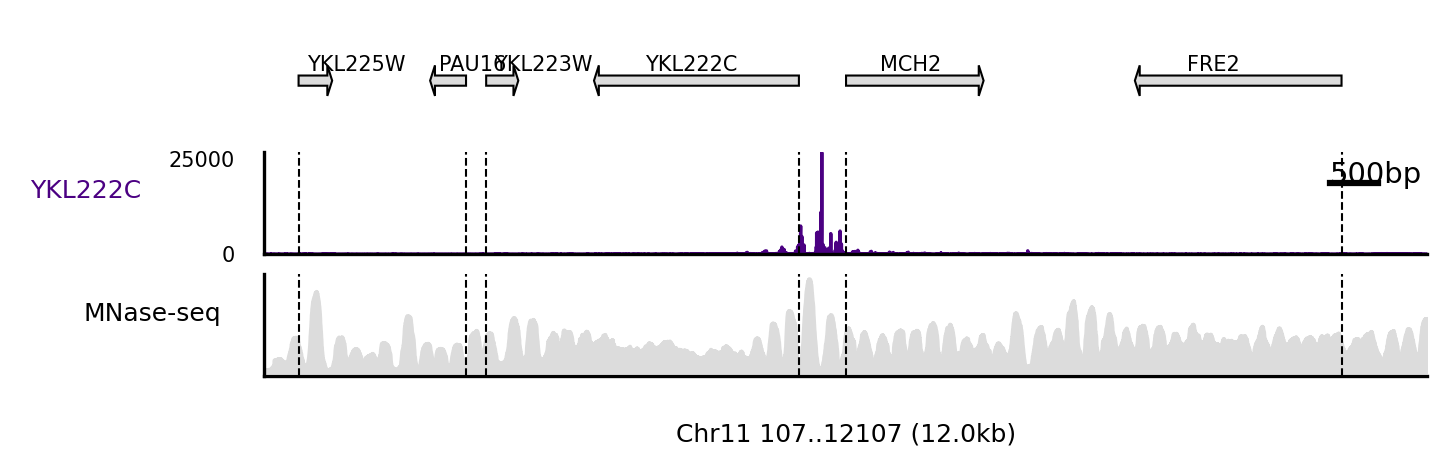

In [22]:
zscored.loc[:, 'YKL222C'].sort_values()

tf='YKL222C'
nnorm = pd.read_parquet(f'outfiles/results/norms/norm_{tf}.gz')
tracks_maxes = nnorm.applymap(lambda x: np.max(x)).quantile(0.2).to_dict()
a,b = df_for_sp.set_index('name').loc['MCH2', ['chr_loc', 'start']].values.astype(int)
draw_promoter(a,b,tracks_maxes, mean_data=nnorm,  title='', save='Figures_reply/YKL222C_track.pdf', gp=gp, verified=False)

/tmp/ipykernel_1903777/3404202617.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  tracks_maxes = nnorm.applymap(lambda x: np.max(x)).quantile(0.2).to_dict()
/tmp/ipykernel_1903777/2889204343.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  genecoords = (gp.query("chr_loc==@chrom & start>@startchr & stop<@stopchr & status=='Verified ORF'").loc[:, ['start', 'stop']].applymap(lambda x: int(x)) - startchr).clip(0)
/tmp/ipykernel_1903777/2889204343.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axi.set_yticklabels(axi.get_yticklabels(), size=5)
/tmp/ipykernel_1903777/2889204343.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  genecoords = (gp.query("chr_loc==@chrom & start>@startchr & stop<@stopchr & status=='Verified ORF'").loc[:, ['start', 'stop']].applymap(lambda x: int(x)) -

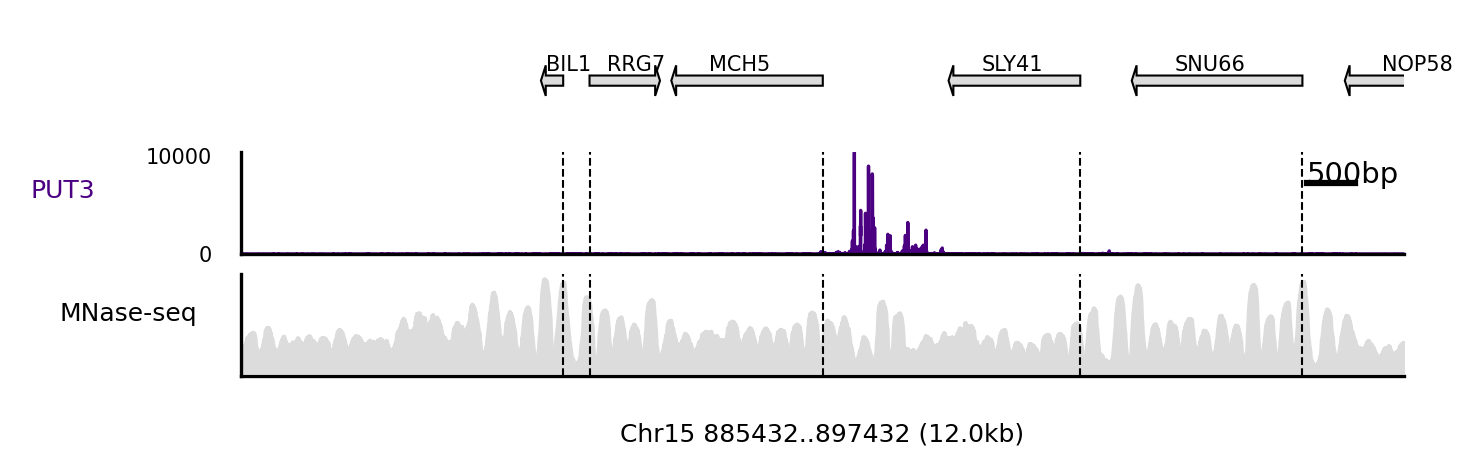

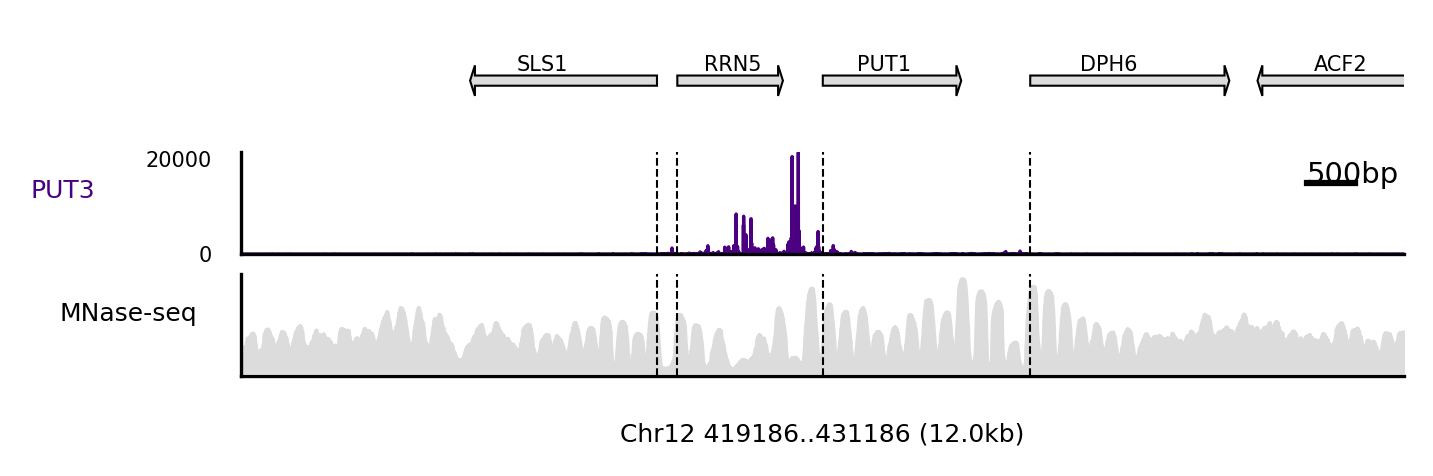

In [23]:
zscored.loc[:, 'PUT3'].sort_values()
tf='PUT3'
nnorm = pd.read_parquet(f'outfiles/results/norms/norm_{tf}.gz')
tracks_maxes = nnorm.applymap(lambda x: np.max(x)).quantile(0.2).to_dict()
a,b = df_for_sp.set_index('name').loc['MCH5', ['chr_loc', 'start']].values.astype(int)
draw_promoter(a,b,tracks_maxes, mean_data=nnorm,  title='', save='Figures_reply/put3_mch5_track.pdf', gp=gp, verified=True)


a,b = df_for_sp.set_index('name').loc['PUT1', ['chr_loc', 'start']].values.astype(int)
draw_promoter(a,b,tracks_maxes, mean_data=nnorm,  title='', save='Figures_reply/put3_PUT1_track.pdf', gp=gp, verified=True)

/tmp/ipykernel_1903777/3095358587.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  tracks_maxes = nnorm.applymap(lambda x: np.max(x)).quantile(0.2).to_dict()
/tmp/ipykernel_1903777/2889204343.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  genecoords = (gp.query("chr_loc==@chrom & start>@startchr & stop<@stopchr & status=='Verified ORF'").loc[:, ['start', 'stop']].applymap(lambda x: int(x)) - startchr).clip(0)
/tmp/ipykernel_1903777/2889204343.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axi.set_yticklabels(axi.get_yticklabels(), size=5)
/tmp/ipykernel_1903777/2889204343.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  genecoords = (gp.query("chr_loc==@chrom & start>@startchr & stop<@stopchr & status=='Verified ORF'").loc[:, ['start', 'stop']].applymap(lambda x: int(x)) -

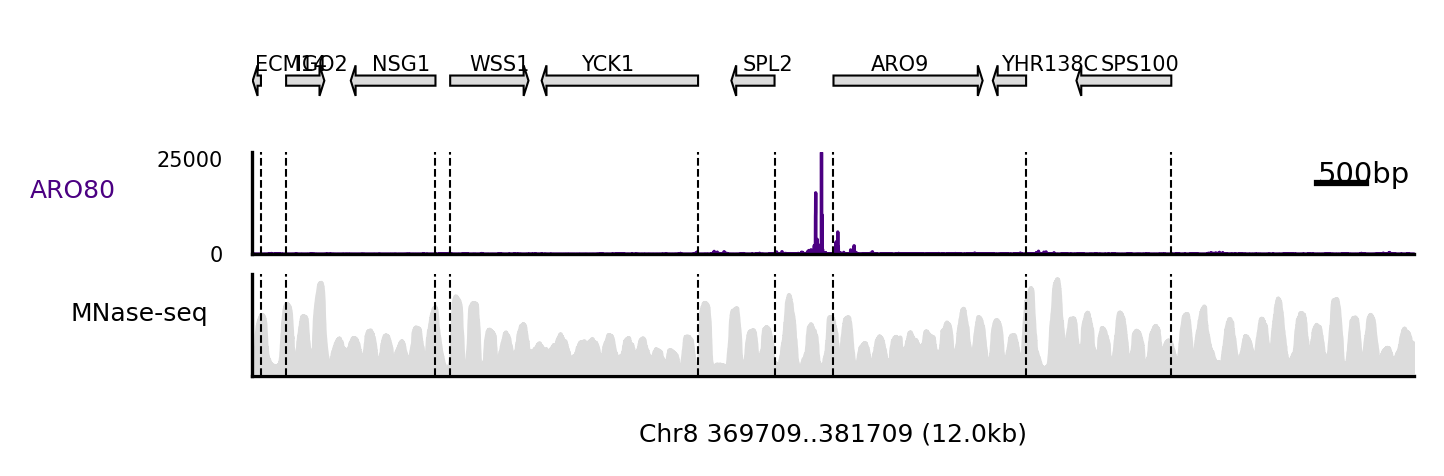

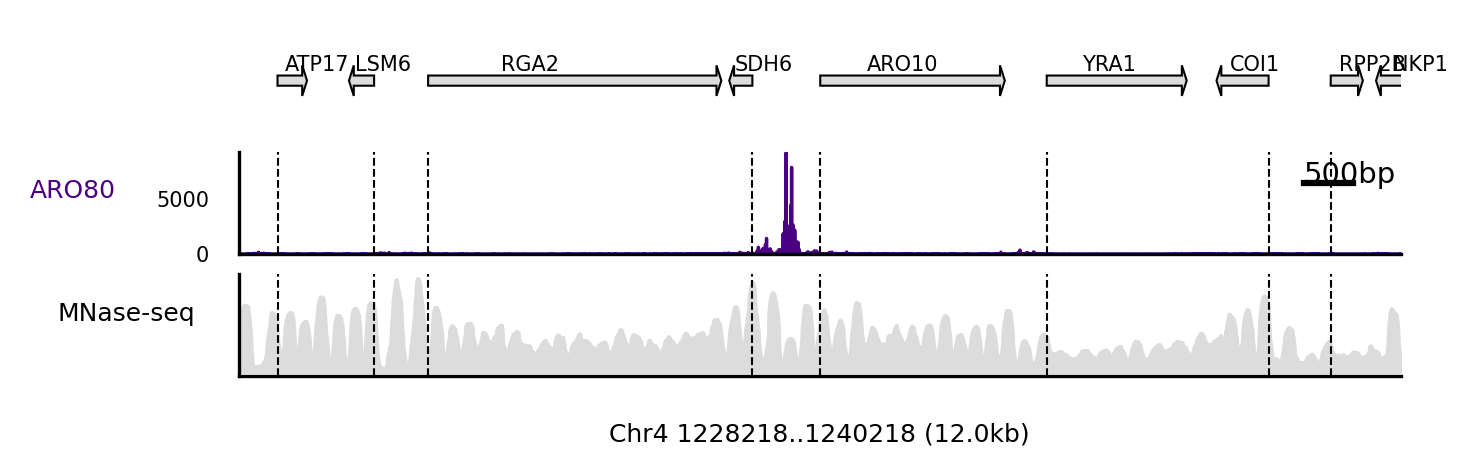

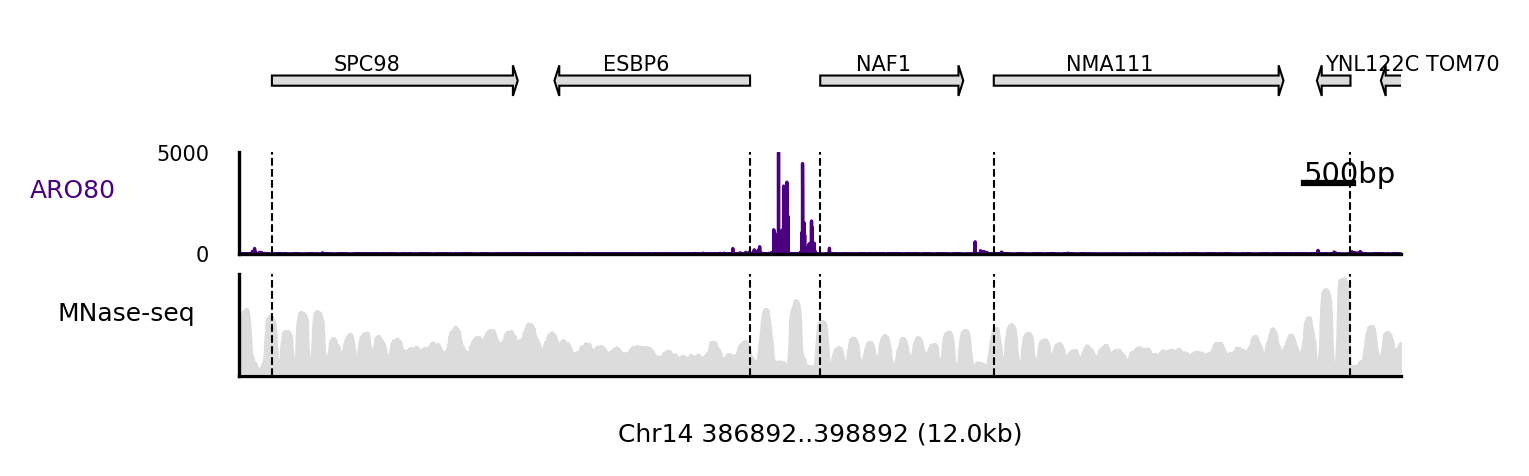

In [24]:
zscored.loc[:, 'ARO80'].sort_values()
tf='ARO80'
nnorm = pd.read_parquet(f'outfiles/results/norms/norm_{tf}.gz')
tracks_maxes = nnorm.applymap(lambda x: np.max(x)).quantile(0.2).to_dict()
a,b = df_for_sp.set_index('name').loc['ARO9', ['chr_loc', 'start']].values.astype(int)
draw_promoter(a,b,tracks_maxes, mean_data=nnorm,  title='', save='Figures_reply/aro80_aro9_track.pdf', gp=gp, verified=True)


a,b = df_for_sp.set_index('name').loc['ARO10', ['chr_loc', 'start']].values.astype(int)
draw_promoter(a,b,tracks_maxes, mean_data=nnorm,  title='', save='Figures_reply/aro80_aro10_track.pdf', gp=gp, verified=True)


a,b = df_for_sp.set_index('name').loc['NAF1', ['chr_loc', 'start']].values.astype(int)
draw_promoter(a,b,tracks_maxes, mean_data=nnorm,  title='', save='Figures_reply/aro80_naf1_track.pdf', gp=gp, verified=True)

In [25]:
go_mf = gseapy.get_library(name='GO_Biological_Process_2018', organism='Yeast')


In [26]:
pd.DataFrame(index=pd.Index(go_mf.keys())).filter(regex='cellular response to amino acid stimulus', axis=0)

Empty DataFrame
Columns: []
Index: [cellular response to amino acid stimulus (GO:0071230)]

In [27]:
from matplotlib.patches import Rectangle


In [28]:
# fig, ax = plt.subplots(1,figsize=(.5,4.5), dpi=200)
# pathways = ['glycolytic process (GO:0006096)','glycolytic fermentation to ethanol (GO:0019655)', 'regulation of glycolytic process by regulation of transcription from RNA polymerase II promoter (GO:0072361)']
# # plot = pd.concat([(zscored.loc[go_mf[x], ['GCR2', 'TYE7']] > 3.5) for x in pathways], axis=1)
# plot = pd.concat([zscored.loc[go_mf[x], ['GCR2', 'TYE7']] for x in pathways], axis=1)
# # sns.heatmap(plot, cmap=sns.color_palette(['white', '#a8daa8']), cbar=False, ax=ax, linewidths=.5, linecolor='k',xticklabels=plot.columns)
# sns.heatmap(plot, cmap='Reds', cbar=True, ax=ax, linewidths=.5, linecolor='k',xticklabels=plot.columns, vmax=8)





# # Sample data
# data = plot.values

# # Create heatmap

# # Add green borders for cells with value > 0.5
# for i in range(data.shape[0]):
#     for j in range(data.shape[1]):
#         value = data[i, j]
#         # if value >= 3.5:
#         #     rect = Rectangle((j, i), 1, 1, fill=False, edgecolor='green', linewidth=1)
#         #     ax.add_patch(rect)
            
            
# plt.show()

# ax.set_ylabel('Glycoloitic process (GO:0006096)')

# fig.savefig('Figures_reply/GCR2_TYE7_go.pdf')

In [29]:
gcr_ts = gcr_data.query("targets=='z-score'").index
tye_ts = tye_data.query("targets=='z-score'").index

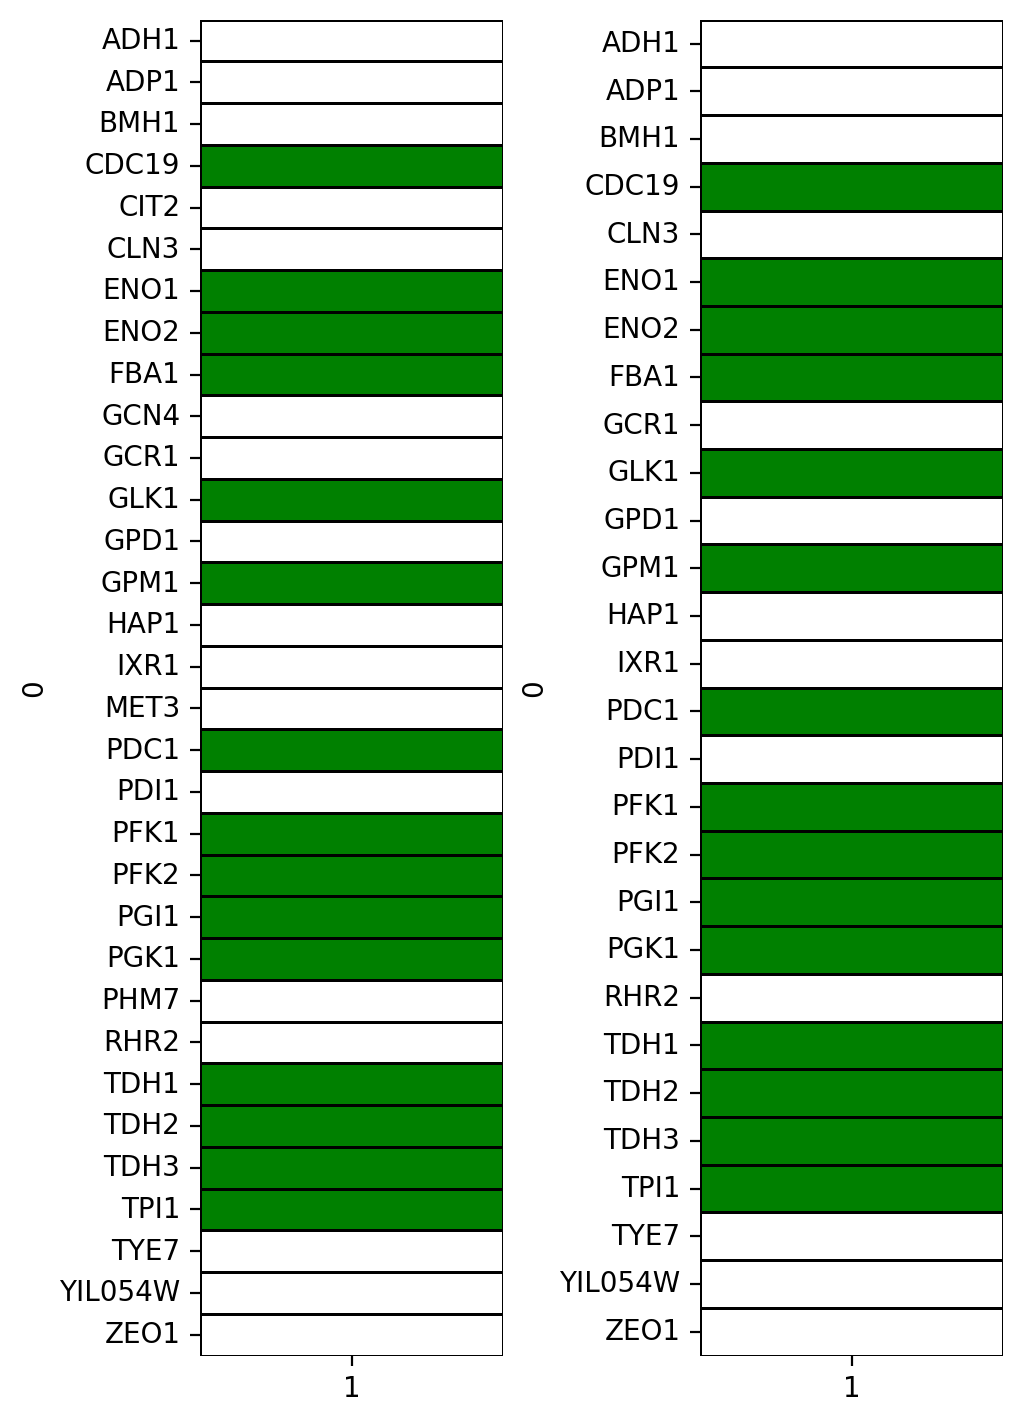

In [30]:
td = dict()
for dat, tf in zip((gcr_ts,tye_ts), ('GCR2', 'TYE7')):
    
    conc = []
    for prom in dat:
        
        if prom in go_mf['pyruvate metabolic process (GO:0006090)']:
            conc.append((prom, True))
        else:
            conc.append((prom,False))
    td[tf] = conc
fig, ax= plt.subplots(1,2, figsize=(5,7), constrained_layout=True)
sns.heatmap(pd.DataFrame(td['GCR2']).set_index(0).sort_index(axis=0)>0, ax=ax[0], cmap=sns.blend_palette(['white', 'green'], n_colors=2), linecolor='k', lw=1, cbar=False)
sns.heatmap(pd.DataFrame(td['TYE7']).set_index(0).sort_index(axis=0)>0, ax=ax[1], cmap=sns.blend_palette(['white', 'green'], n_colors=2), linecolor='k', lw=1, cbar=False)

fig.savefig('Figures_reply/GCR2_TYE7_targets.pdf')

<Axes: ylabel='0'>

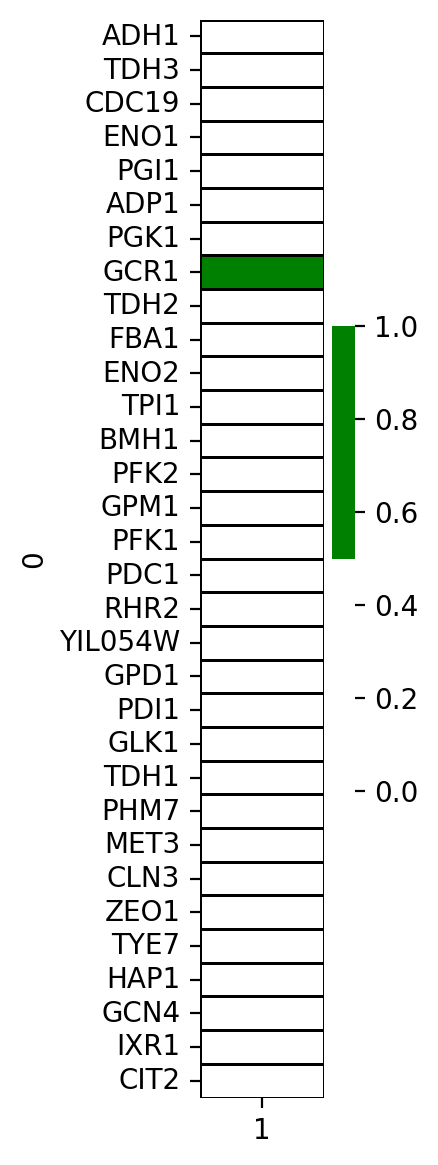

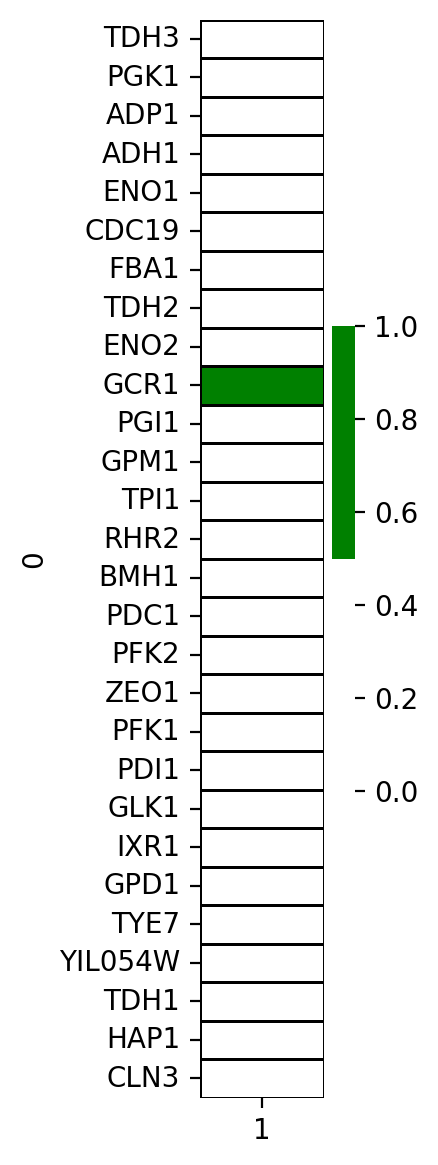

In [31]:
td = dict()
for dat, tf in zip((gcr_ts,tye_ts), ('GCR2', 'TYE7')):
    
    conc = []
    for prom in dat:
        
        if prom in go_mf['regulation of glycolytic process by regulation of transcription from RNA polymerase II promoter (GO:0072361)']:
            conc.append((prom, True))
        else:
            conc.append((prom,False))
    td[tf] = conc
fig, ax= plt.subplots(1, figsize=(1,7))
sns.heatmap(pd.DataFrame(td['GCR2']).set_index(0)>0, ax=ax, cmap=sns.blend_palette(['white', 'green'], n_colors=2), linecolor='k', lw=1)


fig, ax= plt.subplots(1, figsize=(1,7))
sns.heatmap(pd.DataFrame(td['TYE7']).set_index(0)>0, ax=ax, cmap=sns.blend_palette(['white', 'green'], n_colors=2), linecolor='k', lw=1)

<Axes: ylabel='0'>

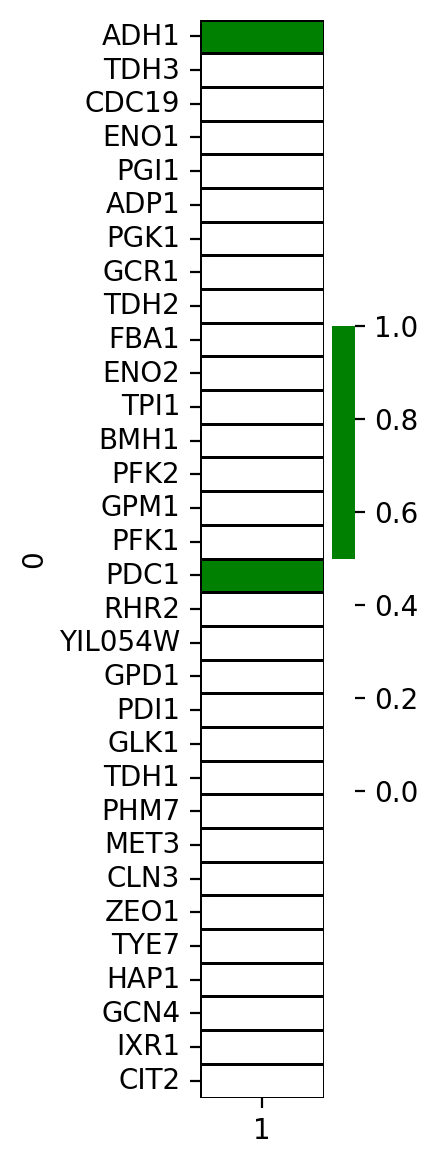

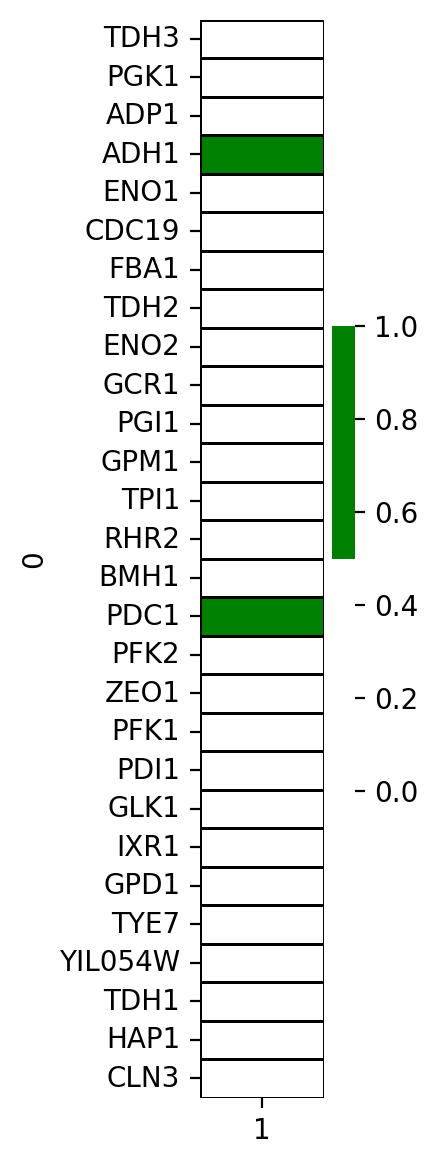

In [32]:
td = dict()
for dat, tf in zip((gcr_ts,tye_ts), ('GCR2', 'TYE7')):
    
    conc = []
    for prom in dat:
        
        if prom in go_mf['glycolytic fermentation to ethanol (GO:0019655)']:
            conc.append((prom, True))
        else:
            conc.append((prom,False))
    td[tf] = conc
fig, ax= plt.subplots(1, figsize=(1,7))
sns.heatmap(pd.DataFrame(td['GCR2']).set_index(0)>0, ax=ax, cmap=sns.blend_palette(['white', 'green'], n_colors=2), linecolor='k', lw=1)


fig, ax= plt.subplots(1, figsize=(1,7))
sns.heatmap(pd.DataFrame(td['TYE7']).set_index(0)>0, ax=ax, cmap=sns.blend_palette(['white', 'green'], n_colors=2), linecolor='k', lw=1)



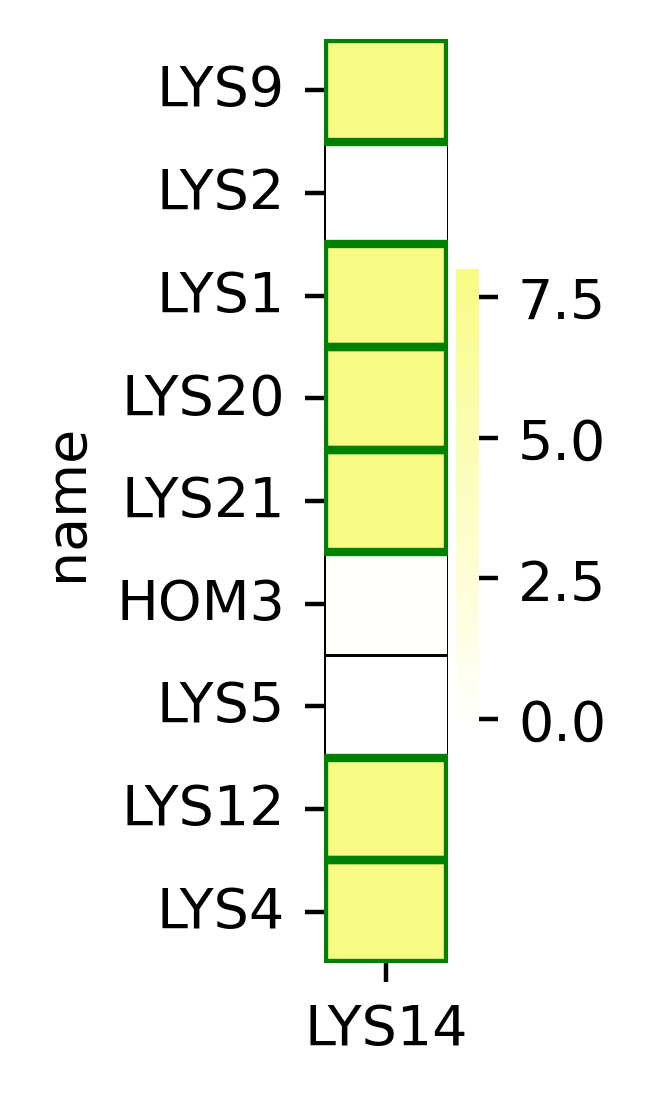

In [33]:
fig, ax = plt.subplots(1,figsize=(.5,3), dpi=200)
pathways = ['lysine biosynthetic process (GO:0009085)']
res = pd.concat([(zscored.loc[go_mf[x], 'LYS14']>=3.5) for x in pathways], axis=1).fillna(0)
res = pd.concat([zscored.loc[go_mf[x], 'LYS14'] for x in pathways], axis=1).fillna(0)


# sns.heatmap(res, cmap=sns.color_palette(['white', '#f8fc84']), cbar=True, ax=ax, linewidths=.5, linecolor='k',)
sns.heatmap(res, cmap=sns.blend_palette(['white', '#f8fc84'], as_cmap=True), cbar=True, ax=ax, linewidths=.5, linecolor='k',vmax=8)

data = res.values

# Create heatmap

# Add green borders for cells with value > 0.5
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        value = data[i, j]
        if value >= 3.5:
            rect = Rectangle((j, i), 1, 1, fill=False, edgecolor='green', linewidth=1.5)
            ax.add_patch(rect)
            
            
plt.show()

ax.set_ylabel('lysine biosynthetic process (GO:0009085)')
fig.savefig('Figures_reply/LYS_go.pdf')

In [34]:
lys_ts = lys_data.query("targets=='z-score'").index

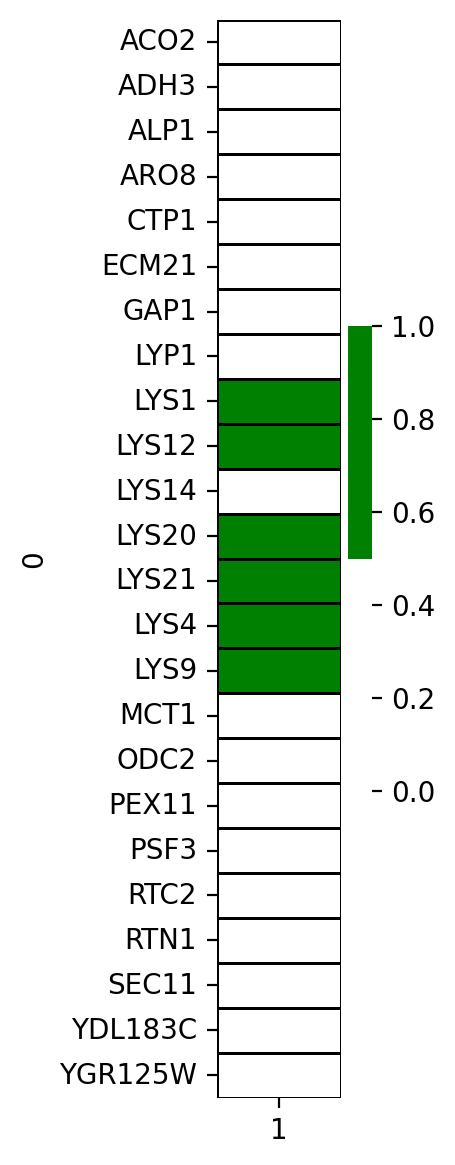

In [35]:
td = dict()
for dat, tf in zip(([lys_ts]), (['LYS14'])):
    
    conc = []
    for prom in dat:
        
        if prom in go_mf['lysine biosynthetic process (GO:0009085)']:
            conc.append((prom, True))
        else:
            conc.append((prom,False))
    td[tf] = conc
fig, ax= plt.subplots(1, figsize=(1,7))
sns.heatmap(pd.DataFrame(td['LYS14']).set_index(0).sort_index()>0, ax=ax, cmap=sns.blend_palette(['white', 'green'], n_colors=2), linecolor='k', lw=1)


fig.savefig('Figures_reply/LYS14_targets.pdf')


<Axes: ylabel='0'>

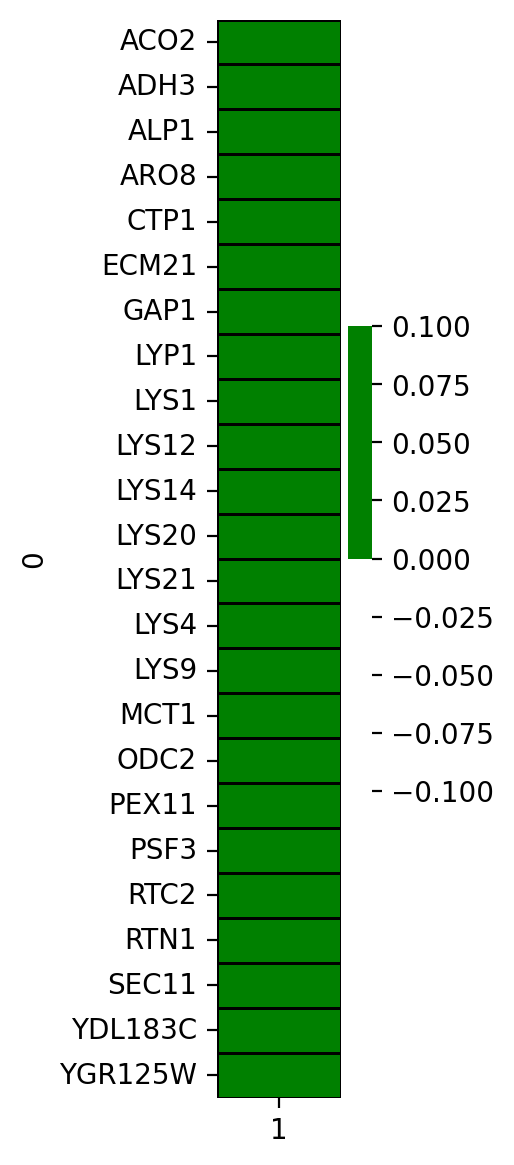

In [36]:
td = dict()
for dat, tf in zip(([lys_ts]), (['LYS14'])):
    
    conc = []
    for prom in dat:
        
        if prom in go_mf['cellular response to amino acid stimulus (GO:0071230)']:
            conc.append((prom, True))
        else:
            conc.append((prom,False))
    td[tf] = conc
fig, ax= plt.subplots(1, figsize=(1,7))
sns.heatmap(pd.DataFrame(td['LYS14']).set_index(0).sort_index()>0, ax=ax, cmap=sns.blend_palette(['white', 'green'], n_colors=2), linecolor='k', lw=1)


# fig, ax= plt.subplots(1, figsize=(1,7))
# sns.heatmap(pd.DataFrame(td['TYE7']).set_index(0)>0, ax=ax, cmap=sns.blend_palette(['white', 'green'], n_colors=2), linecolor='k', lw=1)



/tmp/ipykernel_1903777/465506034.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)


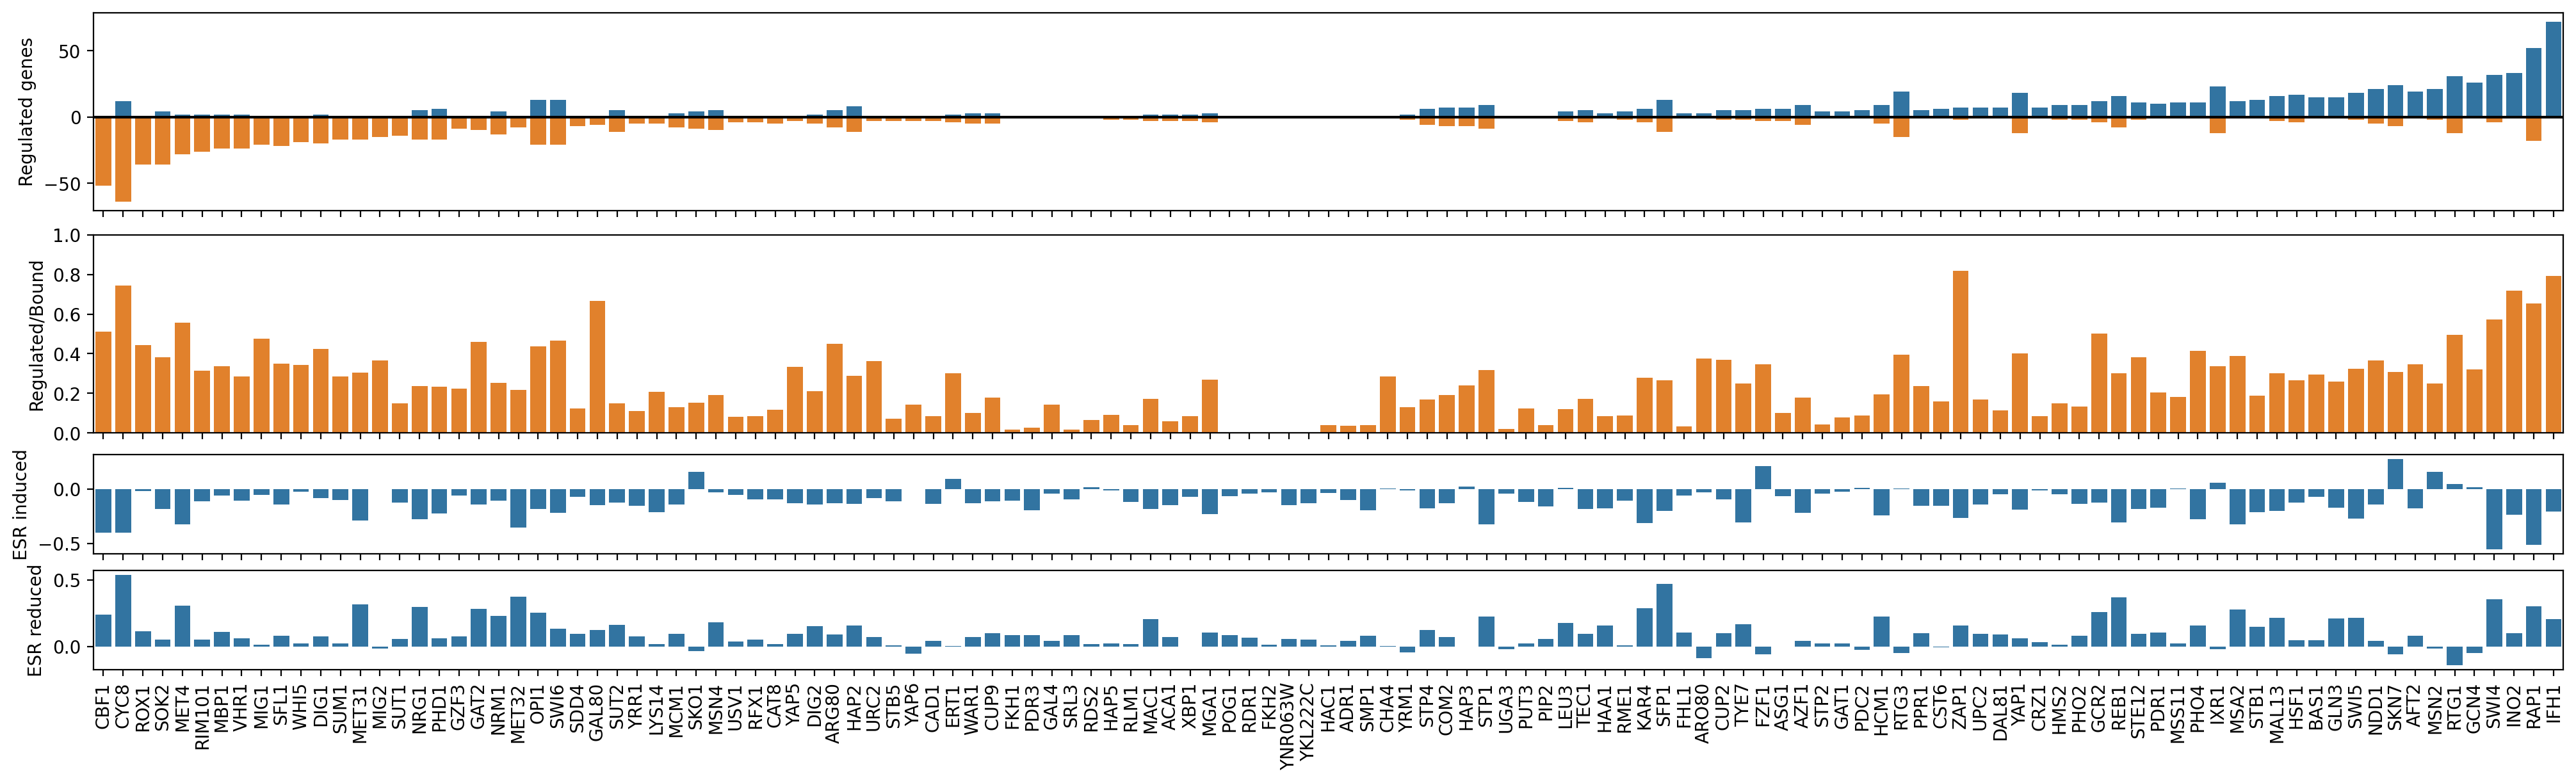

In [37]:
thresh = 3.5
distd = dict()
nums = dict()
for tf in zscored.columns:
    tfd = zscored.loc[expression.index, tf]

    x = tfd[(tfd>=thresh).values]
    medy = expression.loc[:, tf].median()
    y = expression.loc[x.index, tf]
    
    distd[tf] = y[np.abs(y)>=np.log2(1.3)].values
    nums[tf] = y.shape[0]
    
numt = pd.DataFrame(nums, index=['numt']).T

up = (pd.DataFrame({key:pd.Series(value) for key, value in distd.items()})>0).sum().sort_values()
down = -(pd.DataFrame({key:pd.Series(value) for key, value in distd.items()})<0).sum().loc[up.index]
cc = pd.concat([up, down], axis=1)
cc.columns =['UP', 'DOWN']
cc.loc[:, 'SUM'] = cc.sum(axis=1).values
cc = cc.sort_values(by=['SUM', 'UP', 'DOWN'], ascending=(True, True, True))
cc = pd.concat([cc, numt], axis=1)
cc.loc[:, 'TotalReg'] = np.abs(cc.loc[:, ['UP', 'DOWN']]).sum(axis=1)
fig, (ax0,axfrac, ax,ax1) = plt.subplots(4,1, figsize=(20,6), sharex=True, height_ratios = [1,1,.5,.5], constrained_layout=True)

sns.barplot(cc.drop("SUM", axis=1).UP, ax=ax0)
sns.barplot(cc.drop("SUM", axis=1).DOWN, ax=ax0)
ax0.set_ylabel('Regulated genes')
ax0.axhline(0, c='k')


sns.barplot((cc.TotalReg / cc.numt), ax=axfrac)
sns.barplot((cc.TotalReg / cc.numt), ax=axfrac)

axfrac.set_ylim([0,1])
axfrac.set_ylabel('Regulated/Bound')
sns.barplot(expression.loc[names_to_drop_stress, cc.index].median().T, ax=ax)
ax.set_ylabel('ESR induced')
sns.barplot(expression.loc[names_to_drop_ribo, cc.index].median().T, ax=ax1)
ax1.set_ylabel('ESR reduced')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
plt.show()

fig.savefig('Figures_reply/Dual_nature.pdf')

In [38]:
import requests
url = f"https://www.yeastgenome.org/backend/go/GO%3A0006096/locus_details"

# Send GET request
response = requests.get(url)
data = pd.DataFrame(response.json())
data = data.applymap(lambda x : x['display_name'] if isinstance(x, dict) else x)
sorted(data.locus.unique())

/tmp/ipykernel_1903777/4249934078.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data = data.applymap(lambda x : x['display_name'] if isinstance(x, dict) else x)


['6-phosphofructokinase complex',
 'CDC19',
 'EMI2',
 'ENO1',
 'ENO2',
 'ERR1',
 'ERR2',
 'ERR3',
 'FBA1',
 'GLK1',
 'GPM1',
 'GPM2',
 'GPM3',
 'HXK1',
 'HXK2',
 'NGK1',
 'PFK1',
 'PFK2',
 'PGI1',
 'PGK1',
 'PYK2',
 'TDH1',
 'TDH2',
 'TDH3',
 'TPI1']

In [39]:
# tf = 'LYS14'
# td = dict()
# for tf in chec.columns:
#     def get_interactor(row, tf=tf):
#         values = [row['locus1'], row['locus2']]
#         # Return the non-STE12 value, or NaN if both are STE12 or missing
#         for val in values:
#             if val != tf:
#                 return val
#         return None  # fallback if neither value qualifies

#     url = f"https://www.yeastgenome.org/backend/locus/{tf}/regulation_details"

#     # Send GET request
#     response = requests.get(url)

#     # Check if request was successful
#     if response.status_code == 200:
#         data = pd.DataFrame(response.json())  # Parse JSON response
#     data = data.applymap(lambda x : x['display_name'] if isinstance(x, dict) else x)
#     data.loc[:, 'interactor'] = data.loc[:, ['locus1', 'locus2']].apply(get_interactor, axis=1)
#     data = data.drop(['id', 'locus1', 'locus2'], axis=1).set_index('interactor')
#     data = data.query("regulation_of == 'transcription'")
#     prob = list(set(data.index).difference(chec.index))
#     to_add = []
#     for i in prob:
#         if i:
#             if i in gp.reset_index().loc[:, 'name'].values:
#                 # print(f"Name {i}")
#                 ind = gp.reset_index().query("name==@i").index[0]
#                 if ind in df_for_sp.index:
#                     to_add.append(df_for_sp.loc[ind, 'name'])
#             elif i in gp.reset_index().loc[:, 'orf'].values:
#                 ind = gp.reset_index().query("orf==@i").index[0]
#                 if ind in df_for_sp.index:
#                     to_add.append(df_for_sp.loc[ind, 'name'])
#                 # print(f"ORF {i}")

#     nt = list(data.index.drop(prob))
#     nt.extend(to_add)
    
#     td[tf] = nt
# pd.DataFrame({key:pd.Series(value) for key, value in td.items()}).to_parquet('regulators_df.parquet')

In [40]:
reg_df = pd.read_parquet('regulators_df.parquet').T

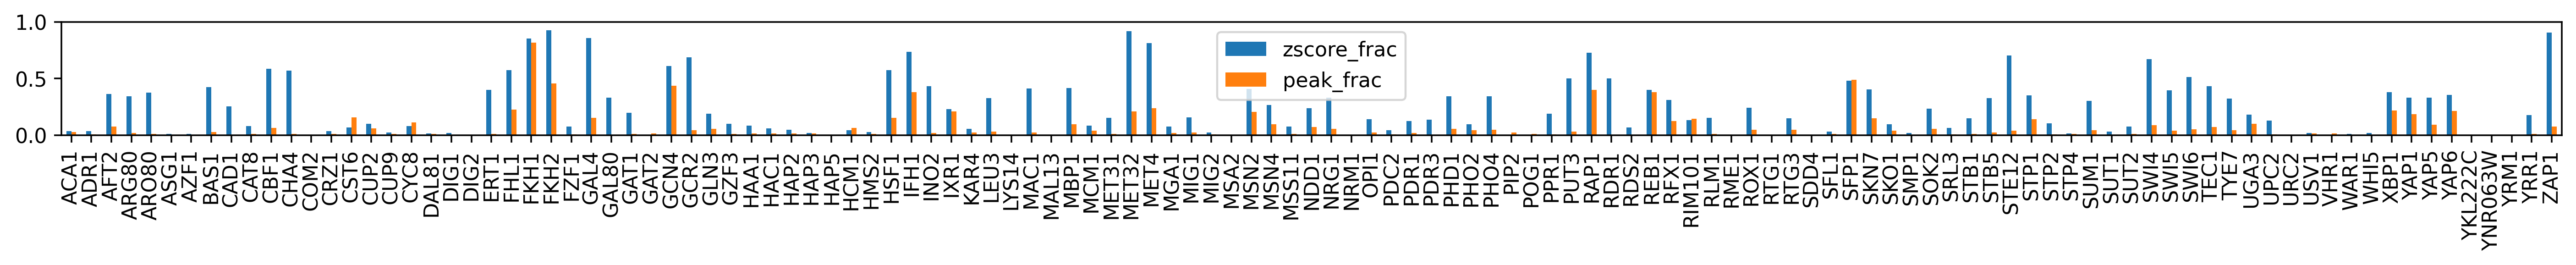

In [41]:
reg_tf_dict = dict()
for i in reg_df.index:
    reg_ts = pd.Index(reg_df.loc[i].dropna().values).drop_duplicates()
    zts = zscored[zscored.loc[:, i]>=3.5].index
    zint = len(set(zts).intersection(reg_ts))
    if zint > 0:
        frac_z =  zint / zts.shape[0]
    else:
        frac_z = 0
    pts = chec.loc[:, i].sort_values(ascending=False).iloc[len(zts):int(total_bs.loc[i])].index
    pint = len(set(pts).intersection(reg_ts))
    if pint > 0 :
        frac_p = pint / pts.shape[0] 
    else:
        frac_p = 0
    

    reg_tf_dict[i] = {'zscore_frac':frac_z, 'peak_frac':frac_p, 'total_regs':reg_ts.shape[0],  }
reg_tf_df = pd.DataFrame(reg_tf_dict)
# reg_tf_df.loc['zscore_frac',:] = reg_tf_df.T.zscore_frac / reg_tf_df.T.total_regs
# reg_tf_df.loc['peak_frac',:] = reg_tf_df.T.peak_frac / reg_tf_df.T.total_regs

fig, ax = plt.subplots(1, figsize=(22,1), dpi=160)
reg_tf_df.iloc[:2,:].T.plot.bar(ax=ax)
ax.set_ylim([0,1])
fig.savefig('Figures_reply/Known_regulators_frac.pdf')

In [42]:
mot_df_list = sorted(glob.glob('mot_calc_dfs/*_calc_df.parquet'))

In [43]:
resd = dict()
for i in mot_df_list:

    k = pd.read_parquet(i).loc[:, ['mot_n', 'targets']]
    k.mot_n = k.mot_n>0
    z = k.query("targets=='z-score'")
    frac_z = z.mot_n.sum() / z.shape[0]

    p = k.query("targets=='peaks'")
    frac_p = p.mot_n.sum() / p.shape[0]
    resd[i] = (frac_z, frac_p)

/tmp/ipykernel_1903777/2964419929.py:10: RuntimeWarning: invalid value encountered in scalar divide
  frac_p = p.mot_n.sum() / p.shape[0]
/tmp/ipykernel_1903777/2964419929.py:10: RuntimeWarning: invalid value encountered in scalar divide
  frac_p = p.mot_n.sum() / p.shape[0]


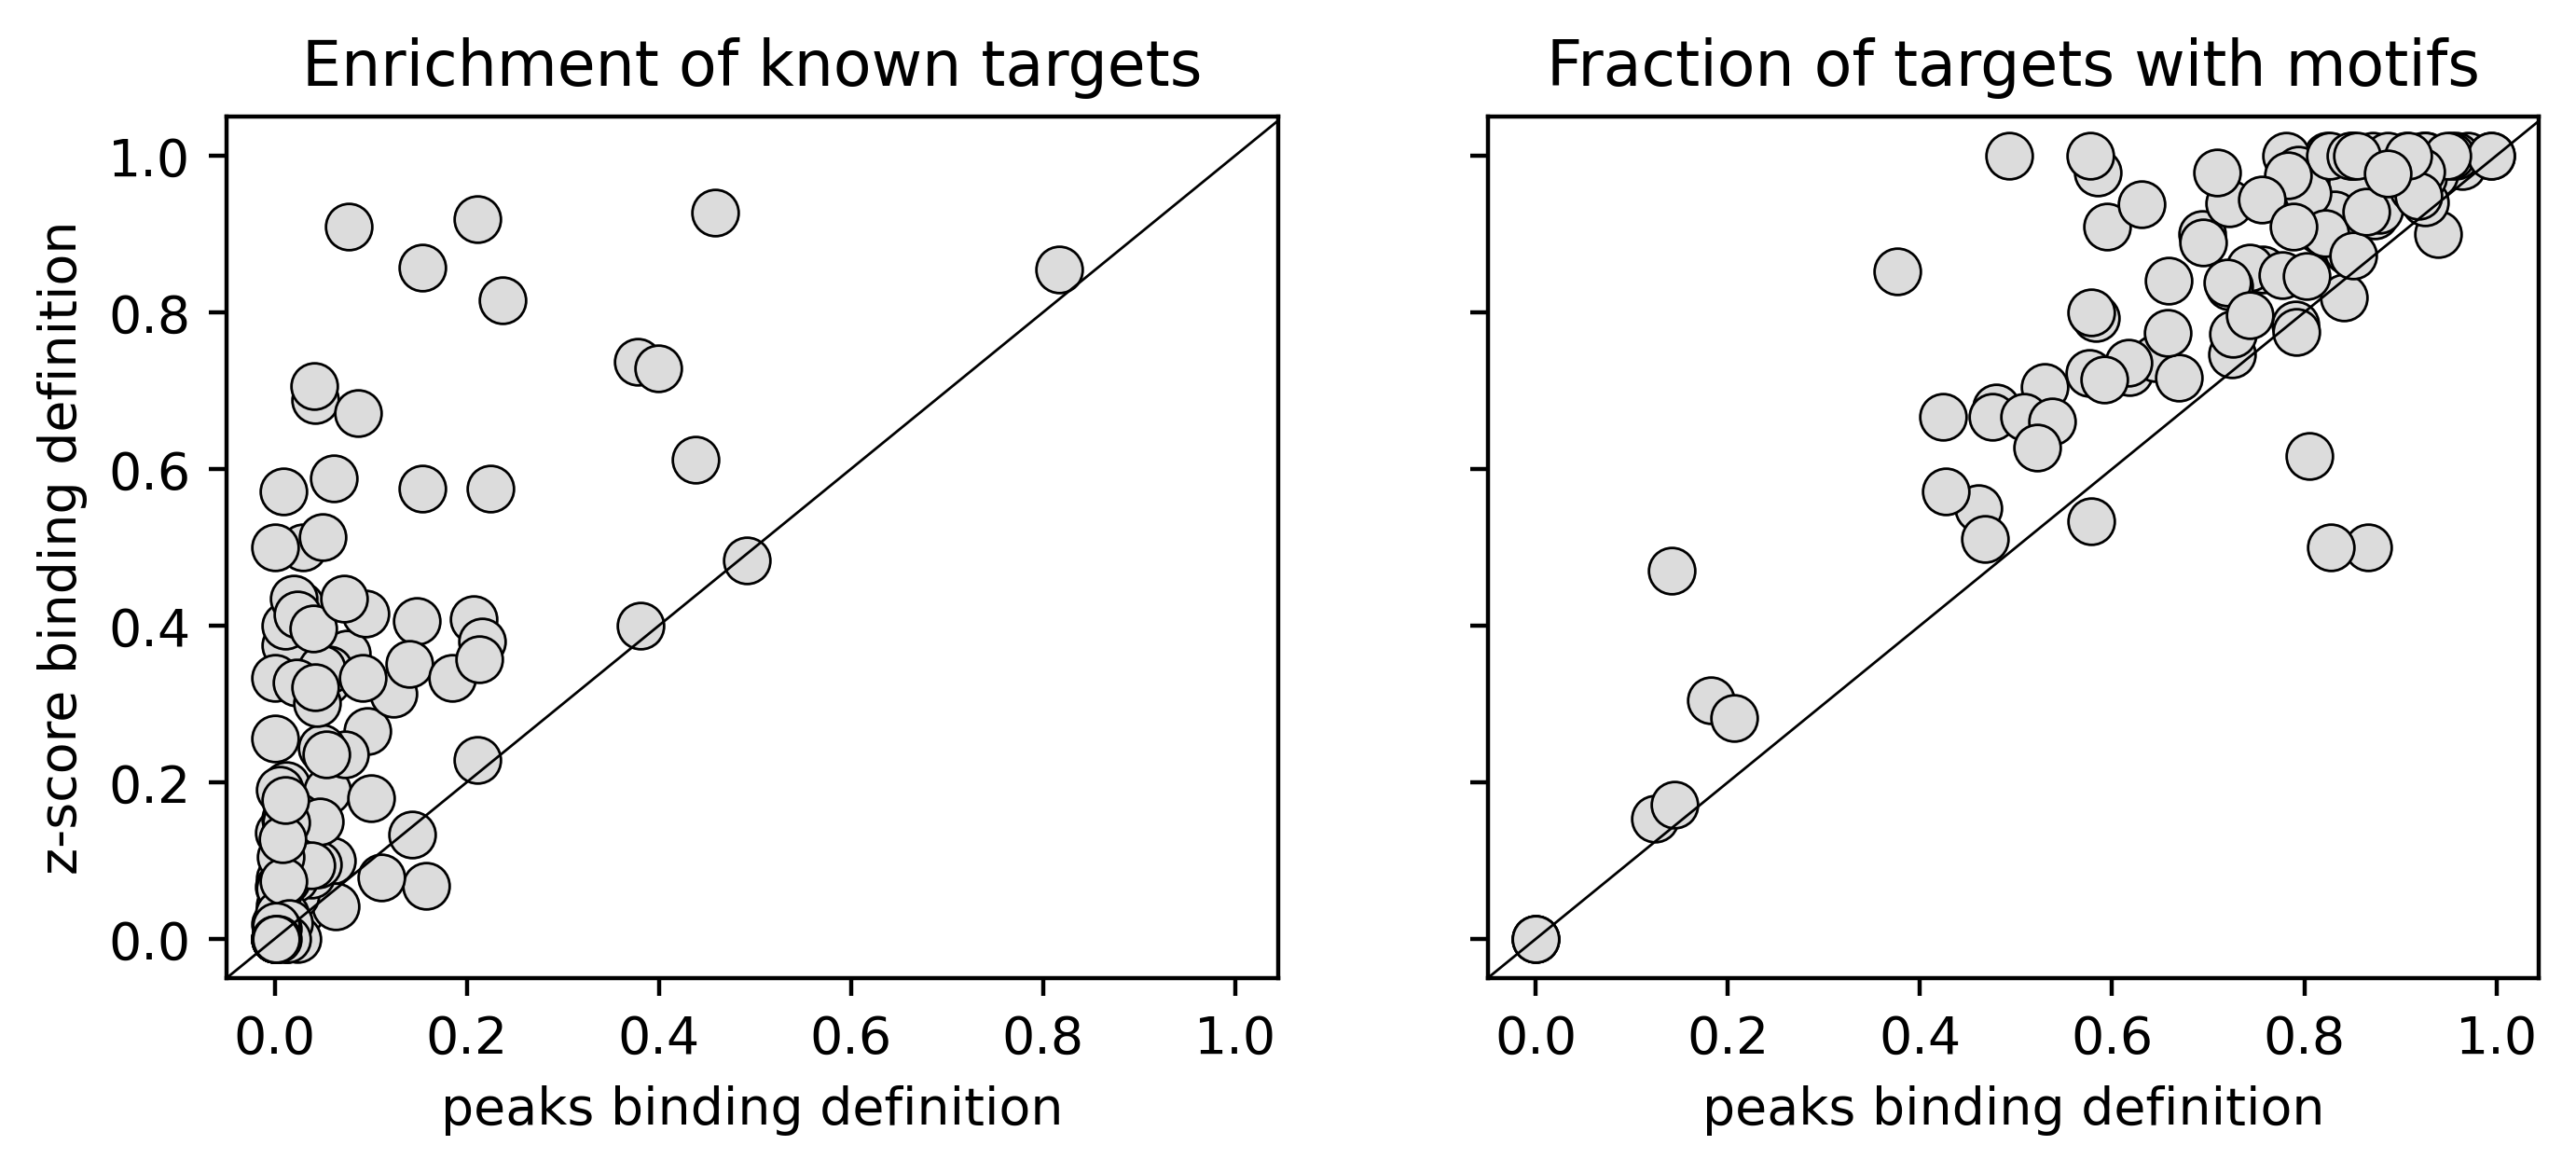

In [44]:

fig, (ax,ax1) = plt.subplots(1,2, figsize=(8,3), dpi=200, sharex=True, sharey=True)
ax.scatter(reg_tf_df.T.peak_frac, reg_tf_df.T.zscore_frac, c='gainsboro', ec='k', lw=.5, s=80)
ax.axline((0,0), slope=1, c='k', lw=.5)
ax.set_title('Enrichment of known targets')

ax.set_ylabel('z-score binding definition')
ax.set_xlabel('peaks binding definition')


ax1.scatter(pd.DataFrame(resd).T.iloc[:, 1], pd.DataFrame(resd).T.iloc[:, 0], c='gainsboro', ec='k', lw=.5, s=80)
ax1.axline((0,0), slope=1, c='k', lw=.5)
ax1.set_title("Fraction of targets with motifs")
# ax1.set_ylabel('z-score binding definition')
ax1.set_xlabel('peaks binding definition')

fig.savefig('Figures_reply/known_ts_motifs.pdf')

In [156]:
np.random.seed(64)
from io import StringIO  

def scramble_motif(path):
    mat = pd.read_csv(path,delimiter='\t', index_col=0)
    arr = list(mat.index)
    np.random.shuffle(arr)
    mat = mat.loc[arr]

    motif_str = "\n".join([
        f"A {' '.join(map(str, mat['A'].tolist()))}",
        f"C {' '.join(map(str, mat['C'].tolist()))}",
        f"G {' '.join(map(str, mat['G'].tolist()))}",
        f"T {' '.join(map(str, mat['T'].tolist()))}"
    ])

    buffer = StringIO(motif_str)
    motif = motifs.read(buffer, "pfm")
    return motif

def get_best_match_signal(lmot,seq, signal, window=50):
    mot_half_len = int(len(lmot.consensus)/2)
    frw_m_score = lmot.pssm.calculate(seq[window:-window])
    rev_m_score = lmot.reverse_complement().pssm.calculate(seq[window:-window])
    
    if np.max(frw_m_score) >= np.max(rev_m_score):
        ex_sig = signal[np.argmax(frw_m_score)+mot_half_len:np.argmax(frw_m_score)+mot_half_len+(window*2)]
    elif np.max(frw_m_score) < np.max(rev_m_score):
        ex_sig = signal[np.argmax(frw_m_score)+mot_half_len:np.argmax(frw_m_score)+mot_half_len+(window*2)]
        ex_sig = ex_sig[::-1]

    return ex_sig


# def get_best_match_signal(lmot,seq, signal, window=300):
#     mot_half_len = int(len(lmot.consensus)/2)
#     frw_m_score = lmot.pssm.calculate(seq[window:-window])
#     rev_m_score = lmot.reverse_complement().pssm.calculate(seq[window:-window])
    
#     if np.max(frw_m_score) >= np.max(rev_m_score):
#         ex_sig = signal[np.argmax(frw_m_score)+mot_half_len:np.argmax(frw_m_score)+mot_half_len+(window*2)]
#     elif np.max(frw_m_score) < np.max(rev_m_score):
#         ex_sig = signal[np.argmax(frw_m_score)+mot_half_len:np.argmax(frw_m_score)+mot_half_len+(window*2)]

#     return ex_sig

In [46]:
nucleosome_signals = pd.read_parquet('/home/labs/barkailab/vovam/Yeast_General_Data/nucleosome_signals_per_promoter.parquet')

In [47]:
tf = 'MSN2'

t_mot = parse_cisbp_motif(os.path.join('/home/labs/barkailab/vovam/Yeast_General_Data/cis_bp/pwms_all_motifs/',motifs_id.loc[tf].values[0]+'.txt'))
t_mot.background = prom_background


scram_mot = scramble_motif(os.path.join('/home/labs/barkailab/vovam/Yeast_General_Data/cis_bp/pwms_all_motifs/',motifs_id.loc[tf].values[0]+'.txt'))
scram_mot.background = prom_background


scram_mot = parse_cisbp_motif(os.path.join('/home/labs/barkailab/vovam/Yeast_General_Data/cis_bp/pwms_all_motifs/',motifs_id.loc['GCN4'].values[0]+'.txt'))
scram_mot.background = prom_background

if (np.isinf(pd.DataFrame(t_mot.pssm)).sum().sum()>0):
    t_mot.pseudocounts= 0.1
if (np.isinf(pd.DataFrame(scram_mot.pssm)).sum().sum()>0):
    scram_mot.pseudocounts= 0.1
    
tfd = zscored.loc[:, tf]
x = chec.loc[:, tf].sort_values()

# return x
dist = t_mot.pssm.distribution(background=prom_background)
threshold = dist.threshold_balanced(1000)
# mot_calc = genes.loc[x[::-1].index, 'seq'].apply(lambda x: np.sum(t_mot.reverse_complement().pssm.calculate(x)>threshold) + np.sum(t_mot.pssm.calculate(x)>threshold))

In [57]:
footprint_scores = pd.read_parquet('msn2_foot_score.parquet')
footprint_scores = pd.DataFrame({key:np.clip(pd.Series(value), 0, np.inf) for key, value in footprint_scores.to_dict()[0].items()}).T

In [49]:
norm_data = pd.read_parquet(f'outfiles/results/prom_signals/{tf}_signals.gz')



In [63]:
df_for_sp

chr_loc     start      stop       name  prom_lengths
0         1.0  151166.0  147594.0       TFC3         741.0
1         1.0  143707.0  147531.0       VPS8         802.0
2         1.0  142174.0  143160.0       EFB1         721.0
4         1.0  141431.0  139503.0       SSA1         792.0
5         1.0  138345.0  137698.0       ERP2         772.0
...       ...       ...       ...        ...           ...
6664      8.0  498859.0  498571.0       NBL1         731.0
6665      8.0  538742.0  538945.0  YHR212W-A        1200.0
6667      8.0  540800.0  541099.0  YHR213W-B        1053.0
6675      9.0   47690.0   47973.0  YIL156W-B         735.0
6692      9.0  350301.0  350510.0  YIL002W-A         716.0

[5358 rows x 5 columns]

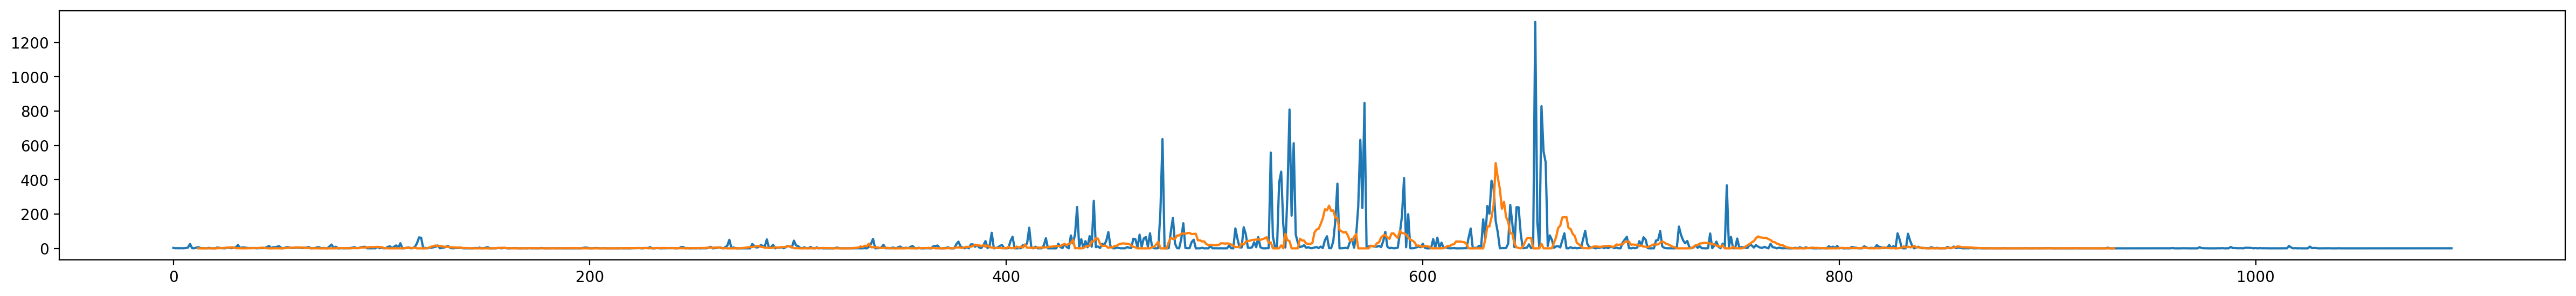

In [58]:
fig, ax = plt.subplots(1, figsize=(30,3))
plt.plot(np.arange(norm_data.loc['TPS2'].dropna().shape[0]), norm_data.loc['TPS2'].dropna())
plt.plot(np.arange(norm_data.loc['TPS2'].dropna().shape[0]), footprint_scores.loc['TPS2'][:norm_data.loc['TPS2'].dropna().shape[0]])

In [59]:
sigd = dict()
sigd_scrambled = dict()
nuc_d = dict()
for gene in genes.index:
    sigd[gene] = get_best_match_signal(t_mot, genes.loc[gene, 'seq'], norm_data.loc[gene].dropna().values)

#     sigd[gene] = get_best_match_signal(t_mot, genes.loc[gene, 'seq'], footprint_scores.loc[gene, :int(df_for_sp.set_index('name').loc[gene, 'prom_lengths'])].values)
    
#     sigd_scrambled[gene] = get_best_match_signal(scram_mot, genes.loc[gene, 'seq'], footprint_scores.loc[gene, :int(df_for_sp.set_index('name').loc[gene, 'prom_lengths'])].values)
    sigd_scrambled[gene] = get_best_match_signal(scram_mot, genes.loc[gene, 'seq'], norm_data.loc[gene].dropna().values)
    # nuc_d[gene] = get_best_match_signal(t_mot, genes.loc[gene, 'seq'], nucleosome_signals.loc[gene].dropna().values)

In [60]:
sig_df = pd.DataFrame(sigd).T
sig_df = sig_df.loc[chec.loc[:, tf].sort_values(ascending=False).index]

sig_df_scram = pd.DataFrame(sigd_scrambled).T
sig_df_scram = sig_df_scram.loc[chec.loc[:, tf].sort_values(ascending=False).index]


# nuc_s_df = pd.DataFrame(nuc_d).T
# nuc_s_df = nuc_s_df.loc[chec.loc[:, tf].sort_values(ascending=False).index]

<Axes: ylabel='name'>

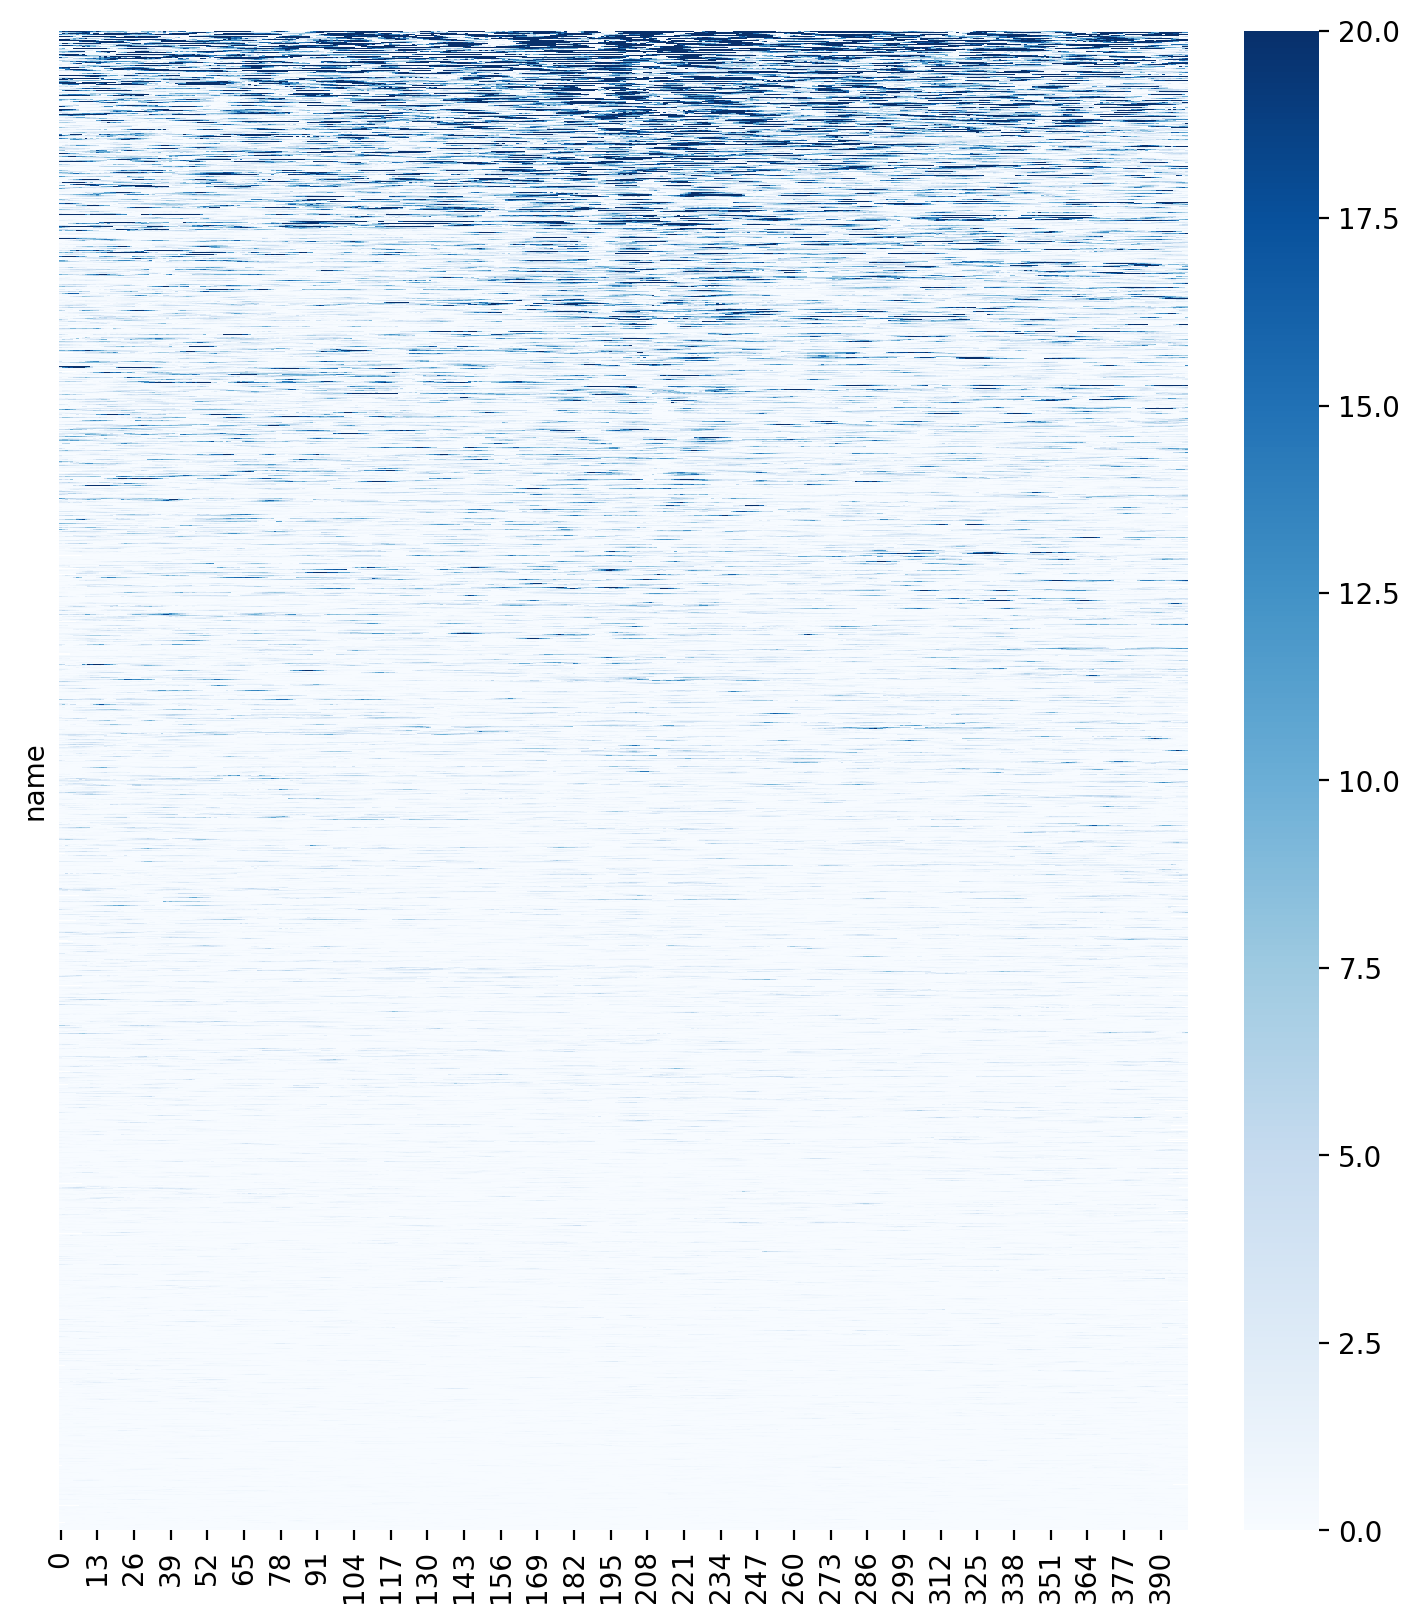

In [61]:
fig, ax = plt.subplots(1, figsize=(7,8), constrained_layout=True)
sns.heatmap(sig_df, yticklabels=False, cmap='Blues', ax=ax, vmax=20)

<Axes: >

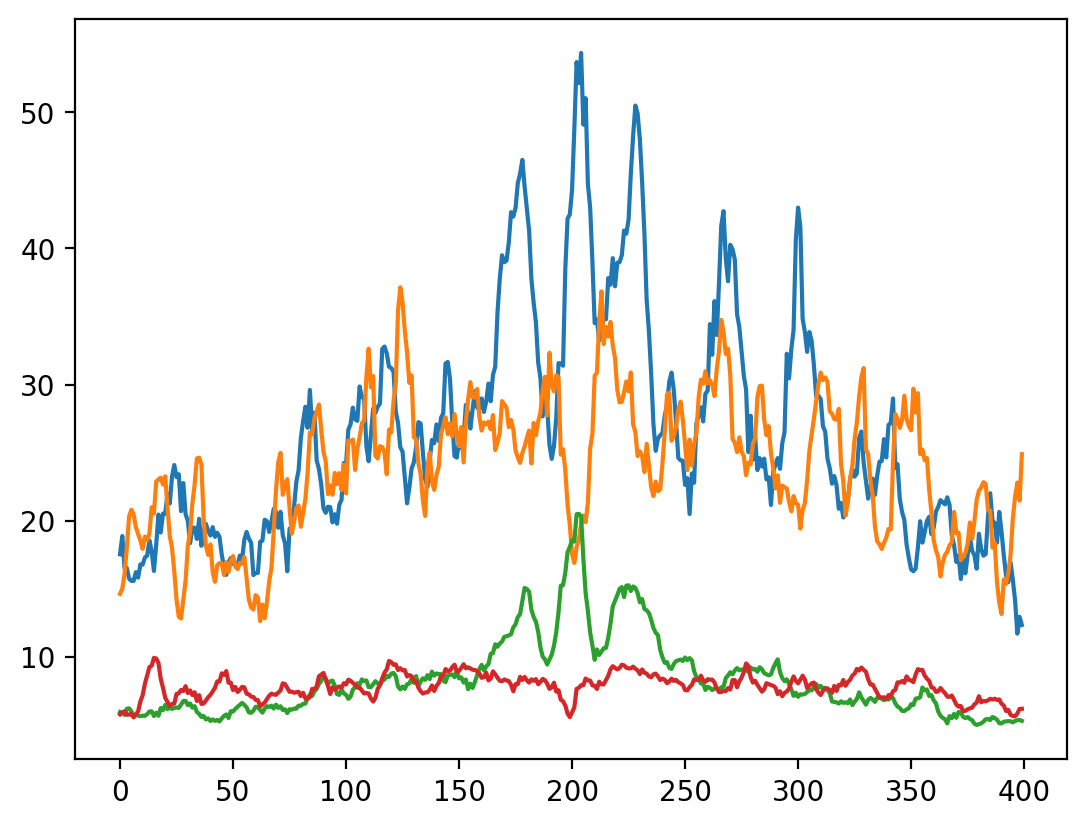

In [62]:
# x = (np.log2(sig_df.iloc[:129,:].mean()) - np.log2(sig_df_scram.iloc[:129,:].mean()))
sig_df.iloc[:129,:].mean().plot()

sig_df_scram.iloc[:129,:].mean().plot()

sig_df.iloc[129:700,:].mean().plot()

sig_df_scram.iloc[129:700,:].mean().plot()

In [ ]:
from Bio import SeqIO
def get_promseqs_per_orf(genome, gene_data):
    
    
    ch, start, stop, name, _ = gene_data        
    if stop > start:
        strand = True
    else:
        strand=False

    if strand:
        seq = genome.loc[int(ch)].seq[int(start):int(stop)]
        rseq = seq.reverse_complement()
        strandness = 'positive'
    else:
        rseq = genome.loc[int(ch)].seq[int(stop):int(start)]
        seq = rseq.reverse_complement()
        strandness = 'negative'

    return seq,rseq,strandness


genome = SeqIO.to_dict(SeqIO.parse("/home/labs/barkailab/vovam/motif_finding_cisbp/for_fimo/cer_normal_chromosomes.fa", "fasta"))
chr_len = np.cumsum(np.load('/home/labs/barkailab/vovam/stuff/chr_len.npy'))
seq_only = dict()
for key, value in genome.items():
    seq_only[key] = (value.seq, value.seq.reverse_complement())

seq_df = pd.DataFrame(seq_only, index=['seq', 'rseq']).transpose()
seq_df = seq_df.drop('mito')
seq_df.index = seq_df.index.astype(int)


prom_seqs_df = pd.DataFrame(map(get_promseqs_per_orf, repeat(seq_df), df_for_sp.values), index=df_for_sp.iloc[:,3], columns = ['seq', 'rseq', 'strand'])

prom_seqs_df.seq = prom_seqs_df.seq.apply(lambda x: str(x))
prom_seqs_df.rseq = prom_seqs_df.rseq.apply(lambda x: str(x))
prom_seqs_df.to_csv('gene_sequences.csv')

In [153]:
of_locs = df_for_sp.loc[:, ['chr_loc', 'start', 'stop']]
of_locs.loc[:, 'genel'] = np.abs((of_locs.start - of_locs.stop))

In [114]:
def get_orf_signals(norm_np, coords_np):
    out_prom=0
    in_prom=14732

    sp_arr = np.empty((int(coords_np.shape[0]), out_prom+in_prom))
    sp_arr[:] = np.nan
    for i in range(coords_np.shape[0]):
        chrom, start, stop = coords_np[i]
        
        if stop - start > 0:
            strand = True
        else:
            strand=False
            
        if strand:
            sp = (norm_np[np.int32(chrom)-1][np.int32(start):np.int32(stop)])
        else:
            sp = (norm_np[np.int32(chrom)-1][np.int32(stop):np.int32(start)])
            sp = sp[::-1]
        sp_arr[i,out_prom +in_prom - len(sp):] = sp
    return sp_arr

In [115]:
norm_signals_msn2 = pd.read_parquet('outfiles/results/norms/norm_MSN2.gz')

In [127]:
res = get_orf_signals(norm_signals_msn2.loc[:, 'MSN2'].to_numpy(), of_locs.iloc[:, :-1].to_numpy())

In [141]:
orf_signals = pd.DataFrame(res)
orf_signals.index = df_for_sp.name

In [157]:

tf = 'MSN2'

t_mot = parse_cisbp_motif(os.path.join('/home/labs/barkailab/vovam/Yeast_General_Data/cis_bp/pwms_all_motifs/',motifs_id.loc[tf].values[0]+'.txt'))
t_mot.background = prom_background

scram_mot = parse_cisbp_motif(os.path.join('/home/labs/barkailab/vovam/Yeast_General_Data/cis_bp/pwms_all_motifs/',motifs_id.loc['GCN4'].values[0]+'.txt'))
scram_mot.background = prom_background

if (np.isinf(pd.DataFrame(t_mot.pssm)).sum().sum()>0):
    t_mot.pseudocounts= 0.1
if (np.isinf(pd.DataFrame(scram_mot.pssm)).sum().sum()>0):
    scram_mot.pseudocounts= 0.1
    


sigd = dict()
sigd_gene = dict()
sigd_scrambled = dict()
sigd_scrambled_gene = dict()

for gene in genes.index:
    sigd_gene[gene] = get_best_match_signal(t_mot, prom_seqs_df.loc[gene, 'seq'], orf_signals.loc[gene].dropna().values)
    # sigd_scrambled_gene[gene] = get_best_match_signal(scram_mot, genes.loc[gene, 'seq'], norm_data.loc[gene].dropna().values)
    sigd[gene] = get_best_match_signal(t_mot, genes.loc[gene, 'seq'], norm_data.loc[gene].dropna().values)
    # sigd_scrambled[gene] = get_best_match_signal(scram_mot, genes.loc[gene, 'seq'], norm_data.loc[gene].dropna().values)


In [171]:
sig_df = pd.DataFrame(sigd).T
sig_df = sig_df.loc[chec.loc[:, tf].sort_values(ascending=False).index]

sig_df_gene = pd.DataFrame(sigd_gene).T
sig_df_gene = sig_df_gene.loc[sig_df_gene.sum(axis=1).sort_values(ascending=False).index]

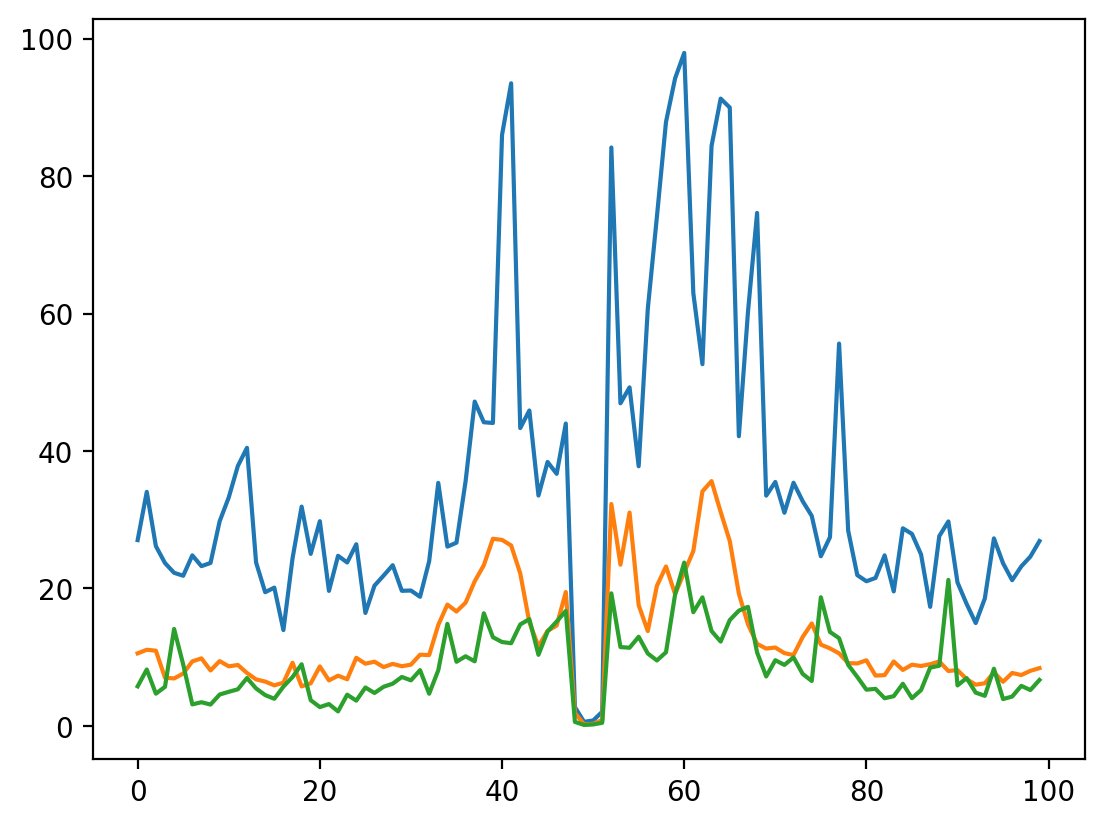

In [172]:
plt.plot(sig_df.iloc[:129,:].mean())
plt.plot(sig_df.iloc[129:700,:].mean())

plt.plot(sig_df_gene.iloc[:129,:].mean())

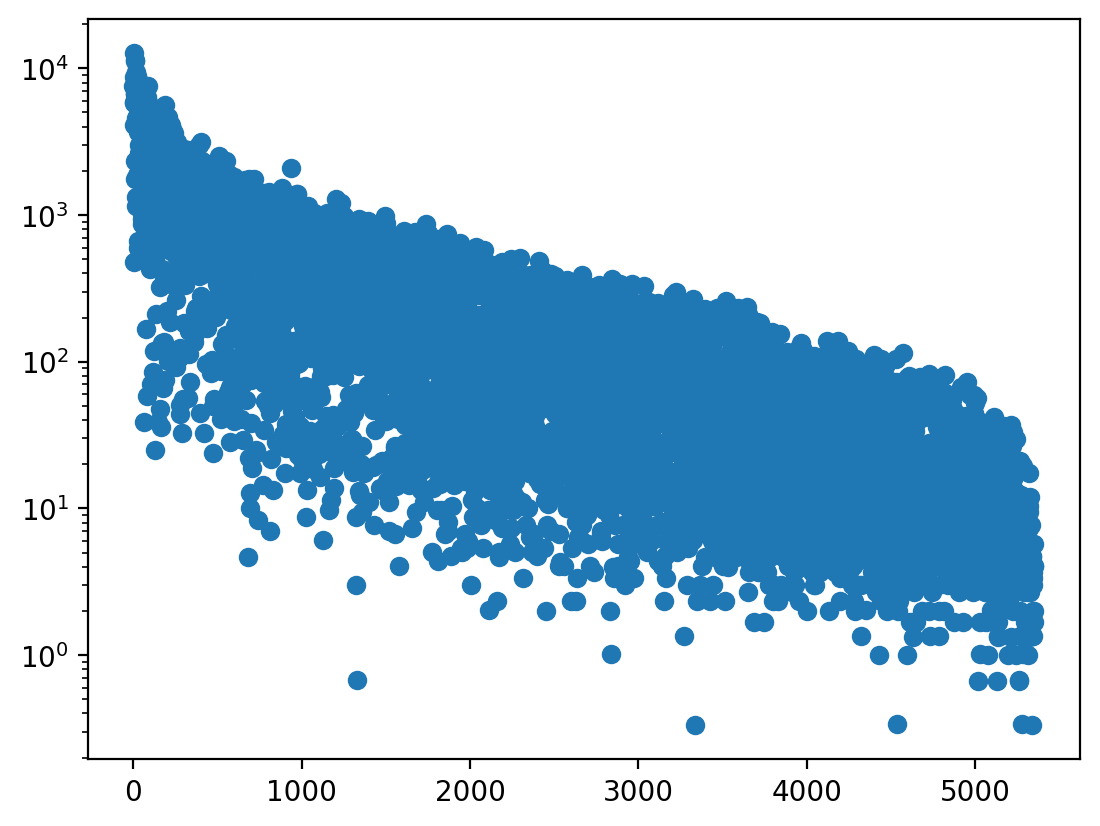

In [189]:
fig, ax = plt.subplots(1)
ax.scatter(np.arange(sig_df.shape[0]), sig_df.sum(axis=1))
# ax.scatter(np.arange(sig_df_gene.shape[0]), sig_df_gene.sum(axis=1))
# ax.set_ylim([1000,10000])
ax.set_yscale('log')


<Axes: ylabel='Density'>

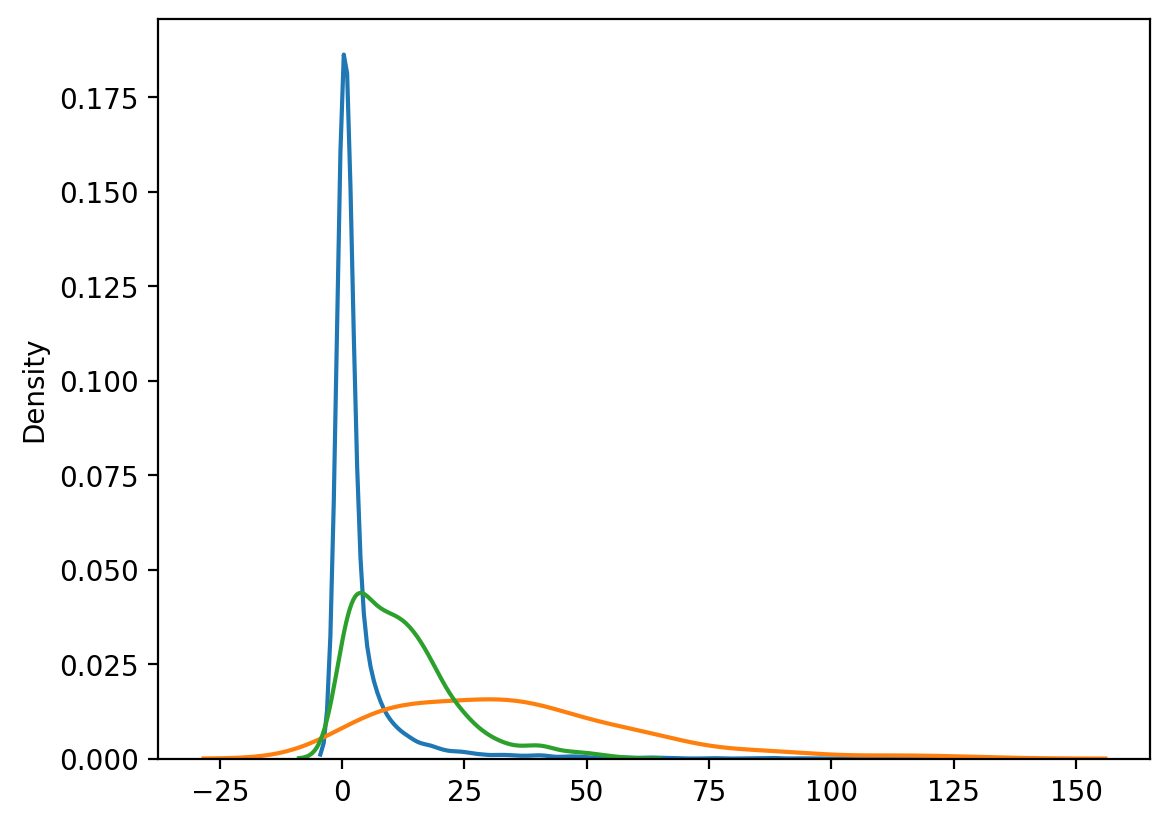

In [197]:
fig, ax = plt.subplots(1)
sns.kdeplot(sig_df.mean(axis=1), ax=ax)
sns.kdeplot(sig_df.mean(axis=1).iloc[:129], ax=ax)
sns.kdeplot(sig_df.mean(axis=1).iloc[129:711], ax=ax)
# sns.kdeplot(sig_df_gene.mean(axis=1), ax=ax)
# ax.set_xscale('log')

<Axes: >

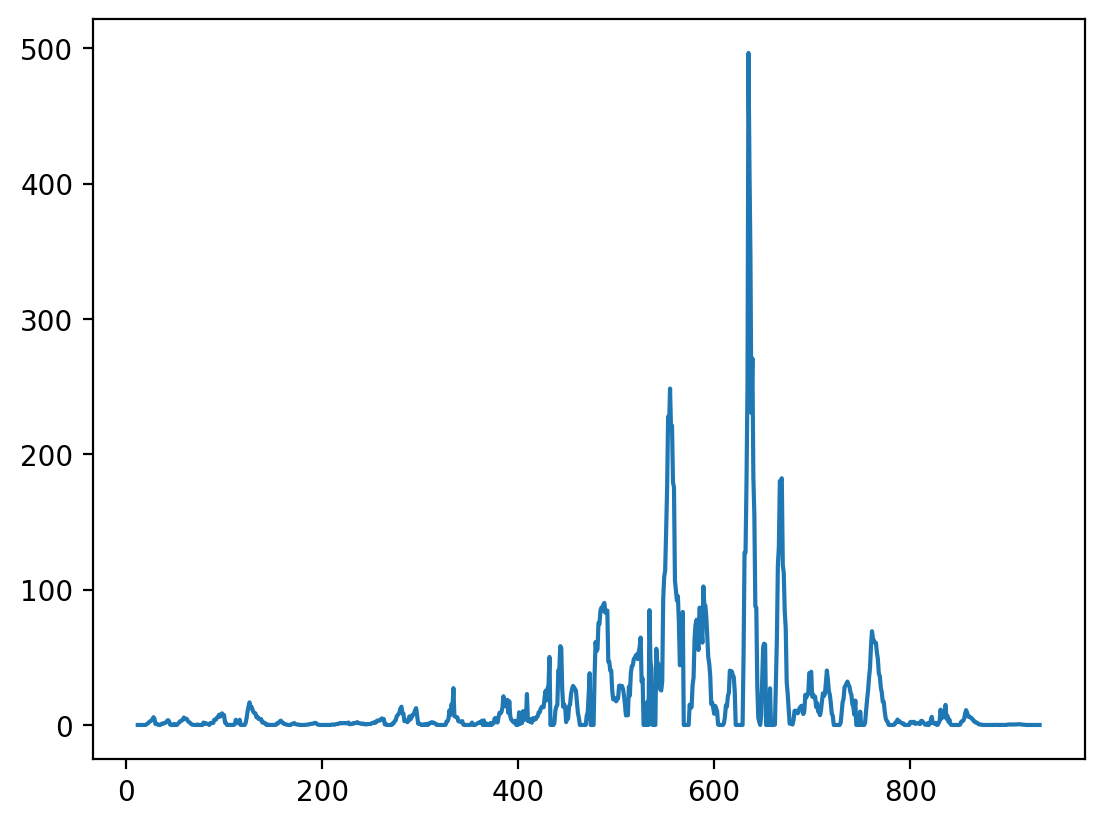

In [201]:
footprint_scores.loc['TPS2'].dropna().plot()

<Axes: >

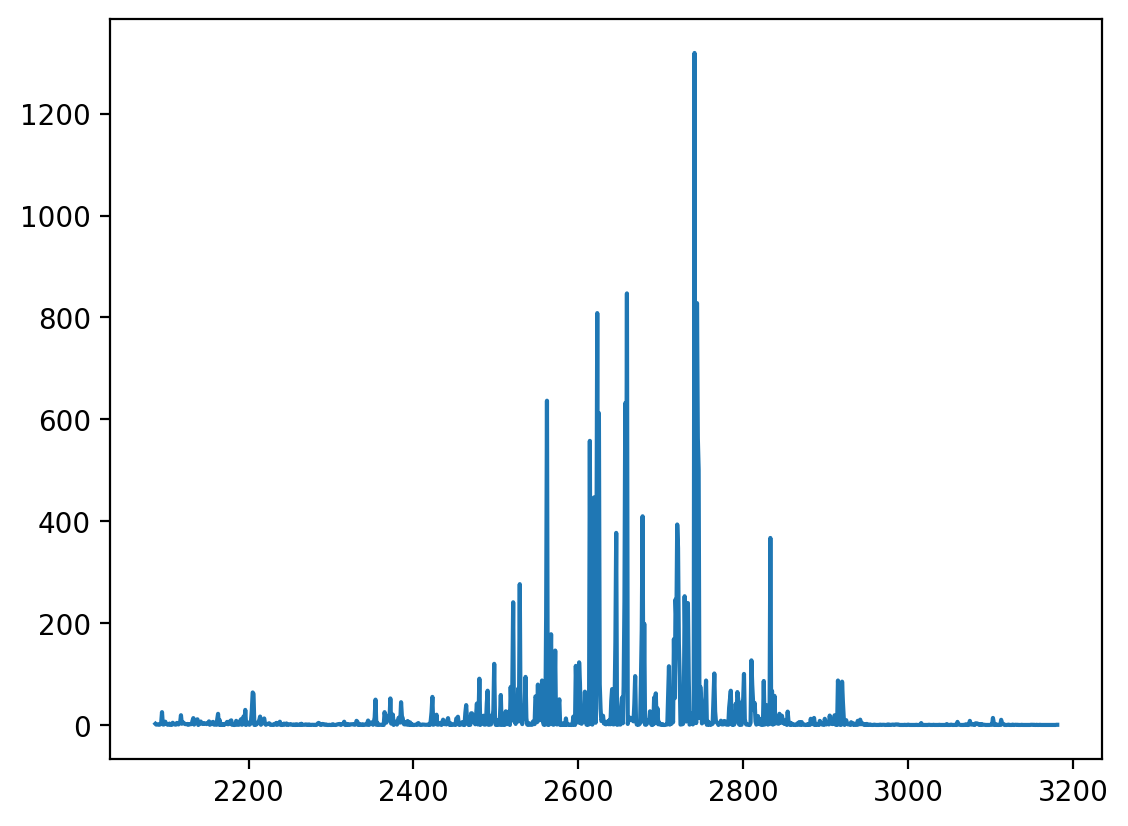

In [202]:
norm_data.loc['TPS2'].dropna().plot()